In [5]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import keras

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from datetime import datetime

tf.compat.v1.disable_eager_execution()

In [10]:
class DQN:
    def __init__(self, env, tau=0.003, gamma=0.99, hidden_size=64, learning_rate=0.0005, batch_size=32):
        self.env = env
        self.tau = tau
        self.gamma = gamma
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.C = 4
        self.memory = deque(maxlen=100000)
        self.count = 0
        
        self.Q, self.target_Q  = self.QNetwork(), self.QNetwork()
    
    def QNetwork(self, state_size=8, action_size=4):
        model = Sequential()
        # we should try different activation function and compare them
        model.add(Dense(self.hidden_size, activation="relu"))
        model.add(Dense(self.hidden_size, activation="relu"))
        model.add(Dense(action_size))
        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        return model
    
    def memory_append(self, experience):
        self.memory.append(experience)
    
    def action(self, state, epsilon):
        if np.random.random() >= epsilon:
            return np.argmax(self.Q.predict(state)[0])
        else:
            return self.env.action_space.sample()
    
    def train_weight(self):
        weights = self.Q.get_weights()
        target_weights = self.target_Q.get_weights()
        for i, _ in enumerate(weights):
            target_weights[i] = target_weights[i] + self.tau * (weights[i] - target_weights[i])
        self.target_Q.set_weights(target_weights)
        
    def learn(self):
        self.count += 1
        self.count %= self.C
        if len(self.memory) < self.batch_size:
            return None
        batch_state, batch_target = [], []
        sample_batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in sample_batch:
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.amax(self.target_Q.predict(next_state)[0])
            target_val = self.Q.predict(state)
            target_val[0][action] = target

            batch_state.append(state[0])
            batch_target.append(target_val[0])
        self.Q.fit(np.array(batch_state), np.array(batch_target), epochs=1, verbose=0)
        if self.count == 0:
            self.train_weight()
    
    def save(self, file):
        self.Q.save(file)

In [11]:
# Training
def train(gamma=0.99, learning_rate=0.0005, name="test", decay_rate=0.0001, batch_size=32, tau=0.003):
    env = gym.make("LunarLander-v2")
    train_episodes = 2000 
    max_steps = 1000
    epsilon=1.0
    epsilon_stop=0.01
    
    # create a score window to terminate training early
    score = []
    score_moving_window = deque(maxlen=100)
    epsilons = []
    # create the agent
    agent = DQN(env=env, learning_rate=learning_rate, gamma=gamma, batch_size=batch_size, tau=tau)
    
    for episode in range(1, train_episodes):
        total_reward = 0
        step = 0
        state = env.reset().reshape(1, 8)
        epsilons.append(epsilon)
        while step < max_steps:
            step += 1
            
            # use epsilon greedy policy to get action
            action = agent.action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1,8])
            total_reward += reward

            # add the transition to replay memory
            agent.memory_append((state, action, reward, next_state, done))
            
            # learn
            agent.learn()
            state = next_state

            if done:
                break
        
        # record score and score window
        score.append(total_reward)
        score_moving_window.append(total_reward)
        # update epsilon
        epsilon = epsilon_stop + (epsilon - epsilon_stop)*np.exp(-decay_rate*step)
        print('Episode: {}'.format(episode),
              'Total reward: {}'.format(total_reward),
              'Mean score: {}'.format(np.mean(score_moving_window)),
              'Explore P: {}'.format(epsilon),
              datetime.now().time())
        if np.mean(score_moving_window) >= 220:
            agent.save(name)
            print("\n Achieve Mean Score of 220 over last 100 episodes with total {} episodes!".format(episode))
            break
    agent.save(name)
    print(print("\n Not achieve Mean Score of 220 over past 100 episodes with total {} episodes!".format(episode)))
    env.close()
    return (score, epsilons)

In [12]:
hidden_sizes = [8, 16, 32, 64, 128]
scores, epsilons = [0,0,0,0,0], [0,0,0,0,0]

In [13]:
for _, hidden_size in enumerate(hidden_sizes):
    scores[_], epsilons[_] = train(hidden_size=hidden_size, name="hidden_size"+str(hidden_size))
    pd.Series(scores[_]).to_csv("scores_hidden_size"+str(hidden_size))
    pd.Series(epsilons[_]).to_csv("epsilons_hidden_size"+str(hidden_size))

Episode: 1 Total reward: -311.27554839760137 Mean score: -311.27554839760137 Explore P: 0.9890717639157014 22:55:05.386399
Episode: 2 Total reward: -97.39518592711538 Mean score: -204.33536716235838 Explore P: 0.9841886231213146 22:55:06.038369
Episode: 3 Total reward: -132.3620671171749 Mean score: -180.34426714729724 Explore P: 0.9760397120292232 22:55:07.114929
Episode: 4 Total reward: -243.10001649631687 Mean score: -196.03320448455213 Explore P: 0.9687256389007275 22:55:08.115042
Episode: 5 Total reward: -320.10408216503333 Mean score: -220.84738002064836 Explore P: 0.9567214808608204 22:55:09.692117
Episode: 6 Total reward: -243.05148535276462 Mean score: -224.54806424266772 Explore P: 0.9471140031888541 22:55:11.105092
Episode: 7 Total reward: -120.30494127537037 Mean score: -209.6561895330538 Explore P: 0.9375112679385795 22:55:12.479414
Episode: 8 Total reward: -214.13685737454364 Mean score: -210.21627301324006 Explore P: 0.9298447843336041 22:55:13.589445
Episode: 9 Total re

Episode: 68 Total reward: -36.64099344811423 Mean score: -273.9151042045043 Explore P: 0.5515876633214628 22:56:26.567128
Episode: 69 Total reward: -318.3553946172284 Mean score: -274.55916638439885 Explore P: 0.5457164142289567 22:56:27.997429
Episode: 70 Total reward: -132.15264572603851 Mean score: -272.5247875178508 Explore P: 0.5371077269565214 22:56:30.145673
Episode: 71 Total reward: -442.0565091140555 Mean score: -274.91255824455794 Explore P: 0.5309765041463343 22:56:31.697936
Episode: 72 Total reward: -397.67049625453046 Mean score: -276.6175296058076 Explore P: 0.5254317727661099 22:56:33.070680
Episode: 73 Total reward: -429.7419066206558 Mean score: -278.71512381149046 Explore P: 0.5209158722705223 22:56:34.247132
Episode: 74 Total reward: -495.72551296248713 Mean score: -281.6476966378553 Explore P: 0.5157815937128782 22:56:35.571166
Episode: 75 Total reward: -714.9329987794322 Mean score: -287.424833999743 Explore P: 0.5077534843539458 22:56:37.654980
Episode: 76 Total r

Episode: 135 Total reward: -334.8274469557731 Mean score: -345.7428505379194 Explore P: 0.3225939122184373 22:57:38.155024
Episode: 136 Total reward: -520.842946614632 Mean score: -347.7101236469065 Explore P: 0.31976221139705524 22:57:39.258521
Episode: 137 Total reward: -370.9052129746988 Mean score: -350.21757445441386 Explore P: 0.31784762703097635 22:57:40.098133
Episode: 138 Total reward: -259.32137871126963 Mean score: -349.091822282019 Explore P: 0.3160672787949878 22:57:40.812515
Episode: 139 Total reward: -470.3522452359968 Mean score: -352.811819289054 Explore P: 0.31344638618897164 22:57:41.980261
Episode: 140 Total reward: -482.90131970354923 Mean score: -353.1650274592721 Explore P: 0.31081785332652934 22:57:43.101300
Episode: 141 Total reward: -286.6604291088253 Mean score: -355.06642749310913 Explore P: 0.30910806907691785 22:57:43.805887
Episode: 142 Total reward: -272.17551923138103 Mean score: -354.77424795750744 Explore P: 0.3071107435263533 22:57:44.681415
Episode:

Episode: 202 Total reward: -149.49590382443984 Mean score: -259.418614305792 Explore P: 0.19910547782682378 22:58:43.005837
Episode: 203 Total reward: -111.32217184499737 Mean score: -259.67667345539326 Explore P: 0.19741116437352257 22:58:44.224877
Episode: 204 Total reward: -87.39410249208477 Mean score: -255.58905632747442 Explore P: 0.19569488863513057 22:58:45.418509
Episode: 205 Total reward: -48.57036208274384 Mean score: -254.71475115999576 Explore P: 0.19410475994670973 22:58:46.490572
Episode: 206 Total reward: -88.48604883357731 Mean score: -250.50206309662164 Explore P: 0.1925282477302571 22:58:47.629690
Episode: 207 Total reward: -35.66945287944614 Mean score: -247.50212365609843 Explore P: 0.19087477538540215 22:58:48.747011
Episode: 208 Total reward: -101.70810924039378 Mean score: -246.3726025226506 Explore P: 0.18950533754781038 22:58:49.732606
Episode: 209 Total reward: -387.2069267282291 Mean score: -246.74567983439553 Explore P: 0.18734641081088133 22:58:51.332420
E

Episode: 268 Total reward: -559.5653466923566 Mean score: -166.0980217800106 Explore P: 0.1179431762824951 22:59:55.879614
Episode: 269 Total reward: -30.730679220052664 Mean score: -165.02793688118345 Explore P: 0.11699744365787744 22:59:57.018568
Episode: 270 Total reward: -479.90179906323516 Mean score: -167.55636264937442 Explore P: 0.1160706034987829 22:59:58.163782
Episode: 271 Total reward: -480.99091917888006 Mean score: -172.77454539321437 Explore P: 0.1149626888926745 22:59:59.500815
Episode: 272 Total reward: -113.80071093111354 Mean score: -172.37083380137585 Explore P: 0.11401186125101474 23:00:00.694148
Episode: 273 Total reward: -313.0951226207003 Mean score: -174.22010539218832 Explore P: 0.11328632057723785 23:00:01.605507
Episode: 274 Total reward: -85.08414826861186 Mean score: -173.3394319899849 Explore P: 0.11261713669717925 23:00:02.433075
Episode: 275 Total reward: -107.3688615765012 Mean score: -173.132798790405 Explore P: 0.11172823991562293 23:00:03.578547
Epi

Episode: 334 Total reward: -96.85646498534221 Mean score: -185.50632385109805 Explore P: 0.07409106374981302 23:01:03.788111
Episode: 335 Total reward: -73.11986965837167 Mean score: -184.2515001196367 Explore P: 0.07351683209457173 23:01:05.011663
Episode: 336 Total reward: -84.48464990007649 Mean score: -183.72143387768722 Explore P: 0.0728722533473062 23:01:06.300595
Episode: 337 Total reward: -118.08899241739886 Mean score: -183.44380539037348 Explore P: 0.07248989996531607 23:01:07.083405
Episode: 338 Total reward: -142.31676402293834 Mean score: -184.27054019469523 Explore P: 0.07214714894483093 23:01:07.807314
Episode: 339 Total reward: -13.946287271695155 Mean score: -183.81329066006106 Explore P: 0.07172598192277674 23:01:08.675972
Episode: 340 Total reward: -137.3170789924437 Mean score: -181.2292598243663 Explore P: 0.07136900745430108 23:01:09.453966
Episode: 341 Total reward: -105.31591038073671 Mean score: -181.7542679901165 Explore P: 0.07079484159155397 23:01:10.632052


Episode: 400 Total reward: -152.92357001878565 Mean score: -124.23176671739971 Explore P: 0.0493464180642739 23:02:07.077417
Episode: 401 Total reward: -137.02136370535948 Mean score: -124.1953441412517 Explore P: 0.04902119433984984 23:02:08.176252
Episode: 402 Total reward: -96.75723823920906 Mean score: -123.53072815479833 Explore P: 0.0487994062287204 23:02:08.896075
Episode: 403 Total reward: -141.03627286344408 Mean score: -123.9370854574864 Explore P: 0.048521053775187895 23:02:09.822966
Episode: 404 Total reward: -137.92979386687443 Mean score: -124.3004913195788 Explore P: 0.04817591972409283 23:02:10.968692
Episode: 405 Total reward: -111.4381020077456 Mean score: -124.26648026299682 Explore P: 0.04783009474473691 23:02:12.161232
Episode: 406 Total reward: -91.66541681895168 Mean score: -123.83349677569699 Explore P: 0.04748740249714516 23:02:13.357383
Episode: 407 Total reward: -106.86073812312164 Mean score: -123.49715199515408 Explore P: 0.047244524589246426 23:02:14.23182

Episode: 466 Total reward: -285.5422727168419 Mean score: -149.04105197040374 Explore P: 0.030855233900141298 23:03:31.136696
Episode: 467 Total reward: -136.03687314830003 Mean score: -149.13260964971772 Explore P: 0.030730477141287064 23:03:31.923048
Episode: 468 Total reward: -122.06889441292611 Mean score: -147.78797086089256 Explore P: 0.030618834271763866 23:03:32.596920
Episode: 469 Total reward: -250.4619576954792 Mean score: -147.97386796358708 Explore P: 0.030003453689657816 23:03:36.651475
Episode: 470 Total reward: -179.01683739990767 Mean score: -148.2503355134857 Explore P: 0.029810358215942703 23:03:37.899568
Episode: 471 Total reward: -170.25184839035137 Mean score: -147.46922979128118 Explore P: 0.029548624836798716 23:03:39.687937
Episode: 472 Total reward: -200.2291918473436 Mean score: -147.81499038416538 Explore P: 0.029274923356569713 23:03:41.509534
Episode: 473 Total reward: -120.71836968912464 Mean score: -149.17046510211026 Explore P: 0.029043102130776502 23:0

Episode: 532 Total reward: -171.6955751325499 Mean score: -206.05376376010597 Explore P: 0.018457088311233598 23:05:29.434127
Episode: 533 Total reward: -2.6632212467446834 Mean score: -204.96675863776815 Explore P: 0.018356209733505192 23:05:31.001719
Episode: 534 Total reward: -220.37196160403454 Mean score: -205.96704934098796 Explore P: 0.018216998062263838 23:05:33.197413
Episode: 535 Total reward: -138.65683233727702 Mean score: -206.67844122686157 Explore P: 0.018175198052771978 23:05:33.865355
Episode: 536 Total reward: -23.104630469141057 Mean score: -205.8209700496696 Explore P: 0.018096281993315155 23:05:35.144024
Episode: 537 Total reward: -228.193672055503 Mean score: -206.66215455515731 Explore P: 0.01803096699203387 23:05:36.227178
Episode: 538 Total reward: -141.95294532382175 Mean score: -206.66811419322661 Explore P: 0.017976541672293893 23:05:37.091659
Episode: 539 Total reward: -291.6502537908892 Mean score: -208.53779050150402 Explore P: 0.017838166507155216 23:05:

Episode: 598 Total reward: -165.19666222670668 Mean score: -165.61760589867504 Explore P: 0.011763860624006103 23:09:05.371809
Episode: 599 Total reward: -148.1805935489084 Mean score: -166.24607164922793 Explore P: 0.011752607962936942 23:09:06.204117
Episode: 600 Total reward: -265.761742252845 Mean score: -167.86707867233065 Explore P: 0.011585825264013125 23:09:20.374922
Episode: 601 Total reward: -293.4801540890434 Mean score: -168.41869670083142 Explore P: 0.01143491403734583 23:09:34.534532
Episode: 602 Total reward: -181.6175487989098 Mean score: -169.18813665067913 Explore P: 0.011298363912655556 23:09:48.876888
Episode: 603 Total reward: -94.01698286069515 Mean score: -168.31456234263842 Explore P: 0.011282235377101005 23:09:50.489952
Episode: 604 Total reward: -35.01849821110886 Mean score: -166.91298335593416 Explore P: 0.011255965931565831 23:09:53.206646
Episode: 605 Total reward: -140.7142859834335 Mean score: -168.27329612179358 Explore P: 0.011217628291268749 23:09:57.

Episode: 664 Total reward: -332.6494600931837 Mean score: -144.9967601937875 Explore P: 0.01003008299981829 23:18:46.318761
Episode: 665 Total reward: -256.20528963205896 Mean score: -146.15455372491223 Explore P: 0.010027220223882357 23:19:01.026726
Episode: 666 Total reward: -198.015877994662 Mean score: -146.73533509246724 Explore P: 0.010024629877096073 23:19:15.172097
Episode: 667 Total reward: -73.02201150765325 Mean score: -146.98909921113523 Explore P: 0.010022286034398155 23:19:29.229930
Episode: 668 Total reward: -171.90404461414073 Mean score: -147.16283528076582 Explore P: 0.010020165237823087 23:19:44.257661
Episode: 669 Total reward: -143.94813448111057 Mean score: -146.94543108601943 Explore P: 0.010018246261725924 23:19:58.911471
Episode: 670 Total reward: -47.92067214959428 Mean score: -147.74946847883328 Explore P: 0.010018135298311887 23:19:59.726090
Episode: 671 Total reward: 2.844591920322131 Mean score: -147.31217132903478 Explore P: 0.010017976407830233 23:20:00.

Episode: 730 Total reward: -260.37720920629704 Mean score: -71.72222034682953 Explore P: 0.010000402628983369 23:29:09.506176
Episode: 731 Total reward: 170.75240706458837 Mean score: -69.50180209631787 Explore P: 0.010000378386250678 23:29:18.292406
Episode: 732 Total reward: 116.1009082459363 Mean score: -66.17146140207626 Explore P: 0.010000345300654932 23:29:31.199657
Episode: 733 Total reward: 200.86029703016214 Mean score: -61.86236216434725 Explore P: 0.010000327738325246 23:29:38.482676
Episode: 734 Total reward: 50.509837212815675 Mean score: -59.32370870186855 Explore P: 0.010000296549900008 23:29:53.158778
Episode: 735 Total reward: 126.3495298254121 Mean score: -57.121234500487816 Explore P: 0.010000271704614774 23:30:06.022773
Episode: 736 Total reward: 125.63786524250192 Mean score: -56.45067476252978 Explore P: 0.010000247872747883 23:30:19.049821
Episode: 737 Total reward: 13.588093884497892 Mean score: -55.23816299145464 Explore P: 0.010000224284537196 23:30:33.901780


Episode: 796 Total reward: -254.21829450696487 Mean score: -53.69408386913412 Explore P: 0.010000030003543797 23:35:14.814141
Episode: 797 Total reward: -303.2136580330252 Mean score: -56.02361740496667 Explore P: 0.010000028922374544 23:35:19.800013
Episode: 798 Total reward: -135.42253908997125 Mean score: -57.16102013069407 Explore P: 0.010000028537399817 23:35:21.601666
Episode: 799 Total reward: -127.00565296014842 Mean score: -61.367242052357135 Explore P: 0.010000028036731824 23:35:23.925331
Episode: 800 Total reward: -10.744835601191014 Mean score: -61.70587561097627 Explore P: 0.01000002766354555 23:35:25.656987
Episode: 801 Total reward: -209.35836937472718 Mean score: -63.742973903642216 Explore P: 0.010000027344502449 23:35:27.185632
Episode: 802 Total reward: -198.7729083264793 Mean score: -65.93396349604974 Explore P: 0.010000026645372648 23:35:30.663081
Episode: 803 Total reward: -227.0366018862039 Mean score: -67.88843450405601 Explore P: 0.010000026317010082 23:35:32.2

Episode: 862 Total reward: -62.01994106464396 Mean score: -116.95898016987857 Explore P: 0.01000001046896851 23:37:34.234692
Episode: 863 Total reward: 129.25782040333002 Mean score: -116.94199520904198 Explore P: 0.01000001006048628 23:37:39.542722
Episode: 864 Total reward: -104.18626239160197 Mean score: -116.19308790115304 Explore P: 0.010000009841572463 23:37:42.460378
Episode: 865 Total reward: -119.76464104580654 Mean score: -115.61322997650448 Explore P: 0.010000009684391846 23:37:44.558470
Episode: 866 Total reward: 136.4963200494759 Mean score: -111.22447783850086 Explore P: 0.010000009342888834 23:37:49.354918
Episode: 867 Total reward: -62.12812169034325 Mean score: -111.08546429396438 Explore P: 0.01000000922590697 23:37:51.041939
Episode: 868 Total reward: -77.35327489832035 Mean score: -109.06750731727548 Explore P: 0.010000009067671463 23:37:53.298763
Episode: 869 Total reward: -43.31622324819763 Mean score: -108.93086381715894 Explore P: 0.010000008928206202 23:37:55.3

Episode: 928 Total reward: -132.88216059861932 Mean score: -94.94513784557013 Explore P: 0.010000000616322755 23:44:20.970387
Episode: 929 Total reward: -158.89551397281258 Mean score: -95.09391255707507 Explore P: 0.01000000055767189 23:44:35.925478
Episode: 930 Total reward: -29.121480883840636 Mean score: -94.32825991483531 Explore P: 0.010000000504602393 23:44:50.125884
Episode: 931 Total reward: -135.40022434924302 Mean score: -94.53303744226552 Explore P: 0.010000000456583126 23:45:05.014795
Episode: 932 Total reward: -133.56862354650164 Mean score: -94.66512508451171 Explore P: 0.010000000413133496 23:45:19.419505
Episode: 933 Total reward: -171.66475059694682 Mean score: -95.24446964578193 Explore P: 0.01000000040657596 23:45:21.547892
Episode: 934 Total reward: -398.2077909028913 Mean score: -97.78444656102575 Explore P: 0.010000000403497696 23:45:22.525316
Episode: 935 Total reward: -436.571277470949 Mean score: -100.6575085742607 Explore P: 0.010000000399962494 23:45:23.6779

Episode: 994 Total reward: -71.99848015051245 Mean score: -118.40285321800106 Explore P: 0.010000000002169012 23:58:11.545394
Episode: 995 Total reward: -74.54454473092595 Mean score: -116.10217851373524 Explore P: 0.010000000001962602 23:58:26.326858
Episode: 996 Total reward: -79.43938598809632 Mean score: -114.15520345058229 Explore P: 0.010000000001775837 23:58:41.293950
Episode: 997 Total reward: -41.505459991646575 Mean score: -112.75686737748705 Explore P: 0.010000000001606843 23:58:56.240519
Episode: 998 Total reward: -62.35870012393436 Mean score: -111.18025524365447 Explore P: 0.010000000001453933 23:59:10.630106
Episode: 999 Total reward: -76.84976650568484 Mean score: -112.1388045246785 Explore P: 0.010000000001315573 23:59:25.193866
Episode: 1000 Total reward: -9.831391034083925 Mean score: -110.96689408325221 Explore P: 0.01000000000119038 23:59:39.528708
Episode: 1001 Total reward: -82.40990768736147 Mean score: -109.45836413293281 Explore P: 0.0100000000010771 23:59:53.

Episode: 1060 Total reward: -94.78983332004303 Mean score: -69.31453854022199 Explore P: 0.010000000000004061 00:13:42.957068
Episode: 1061 Total reward: -103.0441037677528 Mean score: -69.65851550187226 Explore P: 0.01000000000000401 00:13:44.683327
Episode: 1062 Total reward: -81.7497917582306 Mean score: -69.57248889991594 Explore P: 0.010000000000003628 00:13:59.568616
Episode: 1063 Total reward: -76.22298479979804 Mean score: -69.84397506487112 Explore P: 0.010000000000003282 00:14:14.755101
Episode: 1064 Total reward: -111.68139877492379 Mean score: -69.60771817394921 Explore P: 0.01000000000000297 00:14:30.011168
Episode: 1065 Total reward: -61.24770172564409 Mean score: -69.70922148246376 Explore P: 0.010000000000002687 00:14:44.326171
Episode: 1066 Total reward: -71.77752574643463 Mean score: -69.28471891447616 Explore P: 0.010000000000002432 00:14:58.542880
Episode: 1067 Total reward: -76.64520223642918 Mean score: -68.92792005029928 Explore P: 0.010000000000002202 00:15:12.9

Episode: 1126 Total reward: -45.43557158146092 Mean score: -73.99785956713927 Explore P: 0.010000000000000009 00:28:58.067938
Episode: 1127 Total reward: -47.06023534612044 Mean score: -73.56481913430076 Explore P: 0.010000000000000009 00:29:12.542349
Episode: 1128 Total reward: -76.18649110890809 Mean score: -74.81961552705786 Explore P: 0.010000000000000009 00:29:27.662685
Episode: 1129 Total reward: 32.25104276830316 Mean score: -73.77746711066222 Explore P: 0.010000000000000009 00:29:43.852681
Episode: 1130 Total reward: -82.08757891854792 Mean score: -73.69983189120381 Explore P: 0.010000000000000009 00:29:58.556235
Episode: 1131 Total reward: 14.838209683725891 Mean score: -72.69205236556303 Explore P: 0.010000000000000009 00:30:13.752861
Episode: 1132 Total reward: -81.88607760449915 Mean score: -72.59777730091928 Explore P: 0.010000000000000009 00:30:28.280500
Episode: 1133 Total reward: -56.52609312215086 Mean score: -72.4432822009224 Explore P: 0.010000000000000009 00:30:43.5

Episode: 1191 Total reward: -56.62214518543463 Mean score: -58.19632518256648 Explore P: 0.010000000000000009 00:44:17.571872
Episode: 1192 Total reward: -54.143329046899474 Mean score: -57.79616954898528 Explore P: 0.010000000000000009 00:44:32.334480
Episode: 1193 Total reward: -66.32211101760788 Mean score: -58.24768725899106 Explore P: 0.010000000000000009 00:44:47.361452
Episode: 1194 Total reward: -49.76443559176607 Mean score: -57.884388019830546 Explore P: 0.010000000000000009 00:45:02.418827
Episode: 1195 Total reward: 29.118481216563154 Mean score: -56.79521744005242 Explore P: 0.010000000000000009 00:45:16.902918
Episode: 1196 Total reward: -107.77528987348336 Mean score: -57.11306060514862 Explore P: 0.010000000000000009 00:45:32.163724
Episode: 1197 Total reward: -67.73087550505926 Mean score: -57.109032777421 Explore P: 0.010000000000000009 00:45:46.535181
Episode: 1198 Total reward: -68.53590623632567 Mean score: -57.110851639480764 Explore P: 0.010000000000000009 00:46:

Episode: 1256 Total reward: -46.919396904882284 Mean score: -48.22910226994262 Explore P: 0.010000000000000009 00:58:44.600822
Episode: 1257 Total reward: -72.74713818186154 Mean score: -48.20981237783977 Explore P: 0.010000000000000009 00:58:47.958271
Episode: 1258 Total reward: -24.81195459023928 Mean score: -48.25396443219642 Explore P: 0.010000000000000009 00:58:51.662541
Episode: 1259 Total reward: -60.9918170185356 Mean score: -47.98051689003339 Explore P: 0.010000000000000009 00:59:06.032346
Episode: 1260 Total reward: -63.22414309225442 Mean score: -48.08286427306123 Explore P: 0.010000000000000009 00:59:20.796140
Episode: 1261 Total reward: -16.206918655656363 Mean score: -47.76013915429424 Explore P: 0.010000000000000009 00:59:34.977077
Episode: 1262 Total reward: -61.49948806501503 Mean score: -47.631152643939885 Explore P: 0.010000000000000009 00:59:49.816141
Episode: 1263 Total reward: -133.1816173301199 Mean score: -48.321046641443125 Explore P: 0.010000000000000009 01:00

Episode: 1321 Total reward: 120.10105528029166 Mean score: -11.080412347683954 Explore P: 0.010000000000000009 01:11:21.018005
Episode: 1322 Total reward: 130.3476579512951 Mean score: -9.215164812934738 Explore P: 0.010000000000000009 01:11:35.172927
Episode: 1323 Total reward: 23.754229715785755 Mean score: -8.578794460185954 Explore P: 0.010000000000000009 01:11:38.635852
Episode: 1324 Total reward: 119.7355518782239 Mean score: -6.987235160235729 Explore P: 0.010000000000000009 01:11:51.899259
Episode: 1325 Total reward: 123.95626136801825 Mean score: -5.320786442520461 Explore P: 0.010000000000000009 01:12:04.224998
Episode: 1326 Total reward: -21.554568403093114 Mean score: -4.6126326508964555 Explore P: 0.010000000000000009 01:12:07.532787
Episode: 1327 Total reward: -58.12529263439957 Mean score: -4.698866883592832 Explore P: 0.010000000000000009 01:12:21.923583
Episode: 1328 Total reward: -91.53910675533581 Mean score: -7.5195908466485415 Explore P: 0.010000000000000009 01:12:

Episode: 1387 Total reward: 161.12249189044977 Mean score: 35.186055711772084 Explore P: 0.010000000000000009 01:22:19.764093
Episode: 1388 Total reward: -90.43218825628317 Mean score: 34.645524268211865 Explore P: 0.010000000000000009 01:22:30.852528
Episode: 1389 Total reward: 158.16041247314445 Mean score: 36.71871446756638 Explore P: 0.010000000000000009 01:22:44.279355
Episode: 1390 Total reward: -116.38863777833879 Mean score: 35.661381664883194 Explore P: 0.010000000000000009 01:22:45.736857
Episode: 1391 Total reward: 34.211268727308536 Mean score: 36.26971603172261 Explore P: 0.010000000000000009 01:23:01.021443
Episode: 1392 Total reward: 5.038848532308719 Mean score: 34.3686248211397 Explore P: 0.010000000000000009 01:23:15.558093
Episode: 1393 Total reward: -38.102501617782735 Mean score: 34.51169367676213 Explore P: 0.010000000000000009 01:23:22.729201
Episode: 1394 Total reward: 196.7277058983791 Mean score: 36.369514026376756 Explore P: 0.010000000000000009 01:23:31.8146

Episode: 1453 Total reward: 10.410341774571975 Mean score: 41.54691285160934 Explore P: 0.010000000000000009 01:32:45.666332
Episode: 1454 Total reward: -54.27177370925134 Mean score: 40.8243549530889 Explore P: 0.010000000000000009 01:32:52.869631
Episode: 1455 Total reward: 181.53727554155108 Mean score: 41.25164296607555 Explore P: 0.010000000000000009 01:33:03.411875
Episode: 1456 Total reward: 172.2479411977518 Mean score: 40.86100504284677 Explore P: 0.010000000000000009 01:33:12.873403
Episode: 1457 Total reward: -10.710006134575238 Mean score: 41.34011178152835 Explore P: 0.010000000000000009 01:33:15.326115
Episode: 1458 Total reward: 150.95598751293588 Mean score: 42.99677798515837 Explore P: 0.010000000000000009 01:33:24.704766
Episode: 1459 Total reward: 164.5168324392328 Mean score: 44.298760849275375 Explore P: 0.010000000000000009 01:33:36.870677
Episode: 1460 Total reward: 231.50547531132503 Mean score: 46.124320828417055 Explore P: 0.010000000000000009 01:33:43.171632


Episode: 1519 Total reward: 265.61646718028067 Mean score: 97.7741297953486 Explore P: 0.010000000000000009 01:41:56.362915
Episode: 1520 Total reward: 210.0601660860872 Mean score: 99.19912133954536 Explore P: 0.010000000000000009 01:42:09.127315
Episode: 1521 Total reward: -34.86813602722802 Mean score: 97.23411083450839 Explore P: 0.010000000000000009 01:42:14.795677
Episode: 1522 Total reward: 209.50134314836015 Mean score: 97.72074049965121 Explore P: 0.010000000000000009 01:42:24.652428
Episode: 1523 Total reward: 133.89337618299697 Mean score: 99.39666341403726 Explore P: 0.010000000000000009 01:42:38.830484
Episode: 1524 Total reward: 104.99227341146964 Mean score: 98.47888496551113 Explore P: 0.010000000000000009 01:42:52.218510
Episode: 1525 Total reward: 273.74831798168316 Mean score: 101.58819171862667 Explore P: 0.010000000000000009 01:42:56.893765
Episode: 1526 Total reward: 11.09628238273443 Mean score: 102.56645069842543 Explore P: 0.010000000000000009 01:43:00.302248
E

Episode: 1585 Total reward: 216.05044413505914 Mean score: 142.4706361671179 Explore P: 0.010000000000000009 01:51:04.213170
Episode: 1586 Total reward: 85.20082426498247 Mean score: 140.880635204476 Explore P: 0.010000000000000009 01:51:18.186266
Episode: 1587 Total reward: 183.42164393733424 Mean score: 139.91064064659005 Explore P: 0.010000000000000009 01:51:26.170316
Episode: 1588 Total reward: 93.90997119165198 Mean score: 140.0970655238778 Explore P: 0.010000000000000009 01:51:41.051534
Episode: 1589 Total reward: 211.1265445488848 Mean score: 142.50990740201456 Explore P: 0.010000000000000009 01:51:45.278322
Episode: 1590 Total reward: 231.24199841762956 Mean score: 142.74975151677793 Explore P: 0.010000000000000009 01:51:49.673887
Episode: 1591 Total reward: 242.20829243129612 Mean score: 143.35625366596523 Explore P: 0.010000000000000009 01:51:54.903142
Episode: 1592 Total reward: 199.40279004508614 Mean score: 145.14320691196727 Explore P: 0.010000000000000009 01:51:58.997934

Episode: 1651 Total reward: 244.82129956159514 Mean score: 164.4154774205247 Explore P: 0.010000000000000009 01:57:42.343252
Episode: 1652 Total reward: 144.56835825853378 Mean score: 166.1202350156074 Explore P: 0.010000000000000009 01:57:56.581446
Episode: 1653 Total reward: 132.23403906519115 Mean score: 165.27969568318665 Explore P: 0.010000000000000009 01:58:10.617094
Episode: 1654 Total reward: 213.6617479965072 Mean score: 165.96664637237532 Explore P: 0.010000000000000009 01:58:15.767864
Episode: 1655 Total reward: 283.0975840128442 Mean score: 168.8067129234788 Explore P: 0.010000000000000009 01:58:20.396153
Episode: 1656 Total reward: 213.4135405457347 Mean score: 168.00398946924105 Explore P: 0.010000000000000009 01:58:24.623667
Episode: 1657 Total reward: 181.04728545911655 Mean score: 167.9138756593389 Explore P: 0.010000000000000009 01:58:33.194684
Episode: 1658 Total reward: 277.59184824819613 Mean score: 170.88759217524586 Explore P: 0.010000000000000009 01:58:36.927984

Episode: 1717 Total reward: 199.99288180522365 Mean score: 181.36768559212967 Explore P: 0.010000000000000009 02:03:57.532849
Episode: 1718 Total reward: 135.63658201139418 Mean score: 180.6923302434481 Explore P: 0.010000000000000009 02:04:02.799066
Episode: 1719 Total reward: 134.1063549919952 Mean score: 180.25589891634883 Explore P: 0.010000000000000009 02:04:08.946145
Episode: 1720 Total reward: 186.65893294201135 Mean score: 179.74812821928342 Explore P: 0.010000000000000009 02:04:17.937657
Episode: 1721 Total reward: -65.2467989756232 Mean score: 179.37659566620746 Explore P: 0.010000000000000009 02:04:21.077289
Episode: 1722 Total reward: 268.2590614727234 Mean score: 179.7920365792044 Explore P: 0.010000000000000009 02:04:26.591255
Episode: 1723 Total reward: 277.1986960960294 Mean score: 183.2422998438614 Explore P: 0.010000000000000009 02:04:30.506027
Episode: 1724 Total reward: 258.79162197531554 Mean score: 186.16151220061656 Explore P: 0.010000000000000009 02:04:35.713713

Episode: 1783 Total reward: 246.503192940186 Mean score: 183.01481456364448 Explore P: 0.010000000000000009 02:09:48.323213
Episode: 1784 Total reward: 2.194301179695003 Mean score: 180.28445683609345 Explore P: 0.010000000000000009 02:09:51.145456
Episode: 1785 Total reward: 199.50940059840167 Mean score: 180.02409713326648 Explore P: 0.010000000000000009 02:09:55.603940
Episode: 1786 Total reward: 205.22093285502595 Mean score: 180.181072688974 Explore P: 0.010000000000000009 02:10:00.316078
Episode: 1787 Total reward: 207.80576225603517 Mean score: 180.08997542770572 Explore P: 0.010000000000000009 02:10:04.997313
Episode: 1788 Total reward: 201.85249475003974 Mean score: 180.07050438259202 Explore P: 0.010000000000000009 02:10:10.026225
Episode: 1789 Total reward: 221.10666484638864 Mean score: 185.03906365587525 Explore P: 0.010000000000000009 02:10:15.092243
Episode: 1790 Total reward: 256.9680939537532 Mean score: 186.78250342829364 Explore P: 0.010000000000000009 02:10:19.23381

Episode: 1849 Total reward: 142.70765998901567 Mean score: 168.54551595695287 Explore P: 0.010000000000000009 02:15:48.174298
Episode: 1850 Total reward: 194.39495655473087 Mean score: 168.04572959398692 Explore P: 0.010000000000000009 02:16:02.276495
Episode: 1851 Total reward: -501.49429833913655 Mean score: 160.23868764529004 Explore P: 0.010000000000000009 02:16:03.675519
Episode: 1852 Total reward: 139.50386693594464 Mean score: 159.77407919568984 Explore P: 0.010000000000000009 02:16:17.377538
Episode: 1853 Total reward: 188.68458435942404 Mean score: 160.16419683865107 Explore P: 0.010000000000000009 02:16:24.349455
Episode: 1854 Total reward: -40.641413028869124 Mean score: 157.94964809578596 Explore P: 0.010000000000000009 02:16:29.009252
Episode: 1855 Total reward: 216.1187031977028 Mean score: 157.6325632755631 Explore P: 0.010000000000000009 02:16:40.818625
Episode: 1856 Total reward: -511.6905780347593 Mean score: 150.7852502050221 Explore P: 0.010000000000000009 02:16:42.

Episode: 1915 Total reward: 145.2584136698928 Mean score: 84.35990505853243 Explore P: 0.010000000000000009 02:24:18.614554
Episode: 1916 Total reward: -46.90903662373381 Mean score: 82.2752408585764 Explore P: 0.010000000000000009 02:24:23.753200
Episode: 1917 Total reward: 266.8707353346754 Mean score: 82.97613944448143 Explore P: 0.010000000000000009 02:24:30.353545
Episode: 1918 Total reward: 221.34576525745496 Mean score: 87.10823672474697 Explore P: 0.010000000000000009 02:24:34.993377
Episode: 1919 Total reward: 169.80859031381442 Mean score: 86.65644541255075 Explore P: 0.010000000000000009 02:24:41.948191
Episode: 1920 Total reward: 0.8862234814987602 Mean score: 87.23451807390073 Explore P: 0.010000000000000009 02:24:45.426499
Episode: 1921 Total reward: 178.5741611349444 Mean score: 89.46040750980899 Explore P: 0.010000000000000009 02:24:51.789548
Episode: 1922 Total reward: 77.68812483802515 Mean score: 88.32693676133592 Explore P: 0.010000000000000009 02:25:06.572873
Episo

Episode: 1981 Total reward: -151.50193656735965 Mean score: 50.81933325600605 Explore P: 0.010000000000000009 02:31:56.467245
Episode: 1982 Total reward: -262.33308179279027 Mean score: 46.33537465982107 Explore P: 0.010000000000000009 02:32:11.234296
Episode: 1983 Total reward: 182.6772172129583 Mean score: 46.92545556864791 Explore P: 0.010000000000000009 02:32:22.562401
Episode: 1984 Total reward: 125.51919878279166 Mean score: 48.652887820376165 Explore P: 0.010000000000000009 02:32:32.285743
Episode: 1985 Total reward: 99.09927460424369 Mean score: 47.69660443615125 Explore P: 0.010000000000000009 02:32:46.500348
Episode: 1986 Total reward: 187.34559373042526 Mean score: 47.41739556823047 Explore P: 0.010000000000000009 02:32:50.773017
Episode: 1987 Total reward: -172.9873531893875 Mean score: 47.70749527461995 Explore P: 0.010000000000000009 02:33:05.092295
Episode: 1988 Total reward: 178.6886204493473 Mean score: 48.542324334541526 Explore P: 0.010000000000000009 02:33:12.595151

C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
C:\Users\leoqi\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be r

Episode: 1 Total reward: -218.50134006356194 Mean score: -218.50134006356194 Explore P: 0.991817006400586 02:34:33.147070
Episode: 2 Total reward: -158.19368088669273 Mean score: -188.34751047512734 Explore P: 0.9820477639590061 02:34:34.399281
Episode: 3 Total reward: 56.06301070401551 Mean score: -106.87733674874637 Explore P: 0.9742059791742279 02:34:35.479385
Episode: 4 Total reward: -123.13139087065277 Mean score: -110.94085027922297 Explore P: 0.9666187609107091 02:34:36.419393
Episode: 5 Total reward: -109.23225741264972 Mean score: -110.59913170590832 Explore P: 0.9607060728662989 02:34:37.221473
Episode: 6 Total reward: -62.69224864171646 Mean score: -102.61465119520967 Explore P: 0.952942158620952 02:34:38.239321
Episode: 7 Total reward: -470.48721246198426 Mean score: -155.16787423332033 Explore P: 0.9390893781076575 02:34:40.096921
Episode: 8 Total reward: -146.29948022621917 Mean score: -154.0593249824327 Explore P: 0.9303048217255349 02:34:41.299963
Episode: 9 Total rewar

Episode: 68 Total reward: -446.9416241325094 Mean score: -195.1980183669046 Explore P: 0.41145881212411406 02:36:29.087330
Episode: 69 Total reward: -224.10894423191985 Mean score: -195.61701729248455 Explore P: 0.4076232476940763 02:36:30.421372
Episode: 70 Total reward: -500.8358535628676 Mean score: -199.97728638206144 Explore P: 0.40303746697079257 02:36:31.940666
Episode: 71 Total reward: -279.0397859371425 Mean score: -201.09084271382315 Explore P: 0.3969923568637323 02:36:33.985691
Episode: 72 Total reward: -105.76277951793328 Mean score: -199.76684183610246 Explore P: 0.3933716725855865 02:36:35.179057
Episode: 73 Total reward: -499.4179220536511 Mean score: -203.87165115415107 Explore P: 0.38297259426668917 02:36:38.834740
Episode: 74 Total reward: -180.447977093414 Mean score: -203.55511501819518 Explore P: 0.3778977120436024 02:36:40.623271
Episode: 75 Total reward: -259.40229869961627 Mean score: -204.29974413394746 Explore P: 0.37267421180060994 02:36:42.528008
Episode: 76

Episode: 134 Total reward: -115.49921710858494 Mean score: -199.55950315132839 Explore P: 0.028946229544974646 02:43:38.833816
Episode: 135 Total reward: -100.68689268561543 Mean score: -199.24267191476056 Explore P: 0.027143257422991472 02:43:53.573537
Episode: 136 Total reward: -113.85366850451429 Mean score: -199.5903476779751 Explore P: 0.0255118607833454 02:44:08.689694
Episode: 137 Total reward: -38.73364114769298 Mean score: -199.54492005776578 Explore P: 0.025032355977269567 02:44:12.938433
Episode: 138 Total reward: -114.80759238684223 Mean score: -198.3885369561698 Explore P: 0.023601838169470018 02:44:27.808671
Episode: 139 Total reward: -116.4601384628315 Mean score: -198.3280516834133 Explore P: 0.022307452129806213 02:44:43.030091
Episode: 140 Total reward: -79.39619139937493 Mean score: -196.6401930379162 Explore P: 0.021136243207735023 02:44:57.144532
Episode: 141 Total reward: -88.30896350024753 Mean score: -196.48514425157066 Explore P: 0.020076489550707448 02:45:11.8

Episode: 200 Total reward: -72.41418783865828 Mean score: -135.07491957399995 Explore P: 0.010064113838003074 02:57:24.086443
Episode: 201 Total reward: 89.04873974711928 Mean score: -132.25755941284194 Explore P: 0.010058642531222808 02:57:37.101430
Episode: 202 Total reward: -196.6073088819341 Mean score: -131.51774744310126 Explore P: 0.010054727165987322 02:57:46.509581
Episode: 203 Total reward: -177.39937883365675 Mean score: -130.94604085749762 Explore P: 0.010049519187568395 02:58:01.063693
Episode: 204 Total reward: -88.13552889695872 Mean score: -129.02660475082445 Explore P: 0.010048257932678245 02:58:05.060163
Episode: 205 Total reward: -160.8086491206093 Mean score: -129.83552646661144 Explore P: 0.010044883050188674 02:58:15.804441
Episode: 206 Total reward: -108.39618381966652 Mean score: -129.17603613386203 Explore P: 0.010043252724348499 02:58:20.863735
Episode: 207 Total reward: -116.89674766958206 Mean score: -128.78300644508124 Explore P: 0.010040839927664842 02:58:

Episode: 265 Total reward: -110.15605396437647 Mean score: -136.95475267047914 Explore P: 0.010000608937418345 03:08:35.636174
Episode: 266 Total reward: -171.64158515286329 Mean score: -137.3587534488988 Explore P: 0.01000056307650167 03:08:46.563077
Episode: 267 Total reward: -163.43806469394028 Mean score: -137.42289144143862 Explore P: 0.010000509492687928 03:09:01.818953
Episode: 268 Total reward: -167.36124605919525 Mean score: -137.6788873933996 Explore P: 0.01000047097993916 03:09:12.747830
Episode: 269 Total reward: -195.04063598605092 Mean score: -138.0668024454728 Explore P: 0.010000437648248053 03:09:23.136667
Episode: 270 Total reward: -84.38938735064973 Mean score: -138.76874109989717 Explore P: 0.010000396000510777 03:09:37.658020
Episode: 271 Total reward: -143.2045892079412 Mean score: -139.52474184188418 Explore P: 0.010000367423634983 03:09:48.322375
Episode: 272 Total reward: -213.35276464571808 Mean score: -140.57704618360995 Explore P: 0.01000033826022682 03:10:00

Episode: 330 Total reward: -180.59171209577153 Mean score: -163.2400812257554 Explore P: 0.01000000385517153 03:20:45.438615
Episode: 331 Total reward: -155.56809407513208 Mean score: -162.11452203125066 Explore P: 0.010000003631390022 03:20:53.946104
Episode: 332 Total reward: -199.65076524744177 Mean score: -162.7338552546481 Explore P: 0.010000003291079088 03:21:08.753824
Episode: 333 Total reward: -186.7285638220531 Mean score: -163.83972794839445 Explore P: 0.010000003002410607 03:21:21.919326
Episode: 334 Total reward: -70.98933820459132 Mean score: -162.96416607525308 Explore P: 0.01000000271669346 03:21:36.256710
Episode: 335 Total reward: -225.71907793837931 Mean score: -162.94569721607138 Explore P: 0.010000002493570206 03:21:48.752147
Episode: 336 Total reward: -135.19504527028914 Mean score: -163.09478566232463 Explore P: 0.010000002312468344 03:21:59.148341
Episode: 337 Total reward: -133.53948797715722 Mean score: -162.04592988074717 Explore P: 0.010000002176059128 03:22:

Episode: 395 Total reward: -234.87483036458752 Mean score: -161.514100808107 Explore P: 0.010000000021733848 03:33:16.286291
Episode: 396 Total reward: -90.48492355970741 Mean score: -160.4934726104314 Explore P: 0.0100000000196656 03:33:31.441463
Episode: 397 Total reward: -109.73549150826618 Mean score: -160.06573590686145 Explore P: 0.01000000001779417 03:33:45.863472
Episode: 398 Total reward: -212.45463395509296 Mean score: -160.52692028889982 Explore P: 0.010000000016231778 03:33:59.952962
Episode: 399 Total reward: -194.35894579425656 Mean score: -160.68989563705918 Explore P: 0.010000000014864428 03:34:12.617894
Episode: 400 Total reward: -109.55855162240135 Mean score: -160.1321370936136 Explore P: 0.01000000001344989 03:34:27.187786
Episode: 401 Total reward: -181.14011802555495 Mean score: -159.74894962830336 Explore P: 0.010000000012449382 03:34:38.026211
Episode: 402 Total reward: -150.66598096934612 Mean score: -159.2685919367283 Explore P: 0.010000000011264666 03:34:52.8

Episode: 461 Total reward: -97.45249072598398 Mean score: -135.1413612465636 Explore P: 0.010000000000034318 03:49:07.337057
Episode: 462 Total reward: -105.3589629032005 Mean score: -134.8016992401331 Explore P: 0.010000000000031052 03:49:22.170698
Episode: 463 Total reward: -98.54987944367062 Mean score: -134.53884657262475 Explore P: 0.010000000000028098 03:49:36.492290
Episode: 464 Total reward: -68.09107573193988 Mean score: -133.06592946582035 Explore P: 0.010000000000025424 03:49:52.064526
Episode: 465 Total reward: -112.72181838109907 Mean score: -133.34540275409273 Explore P: 0.010000000000023004 03:50:06.840603
Episode: 466 Total reward: -161.1388883680522 Mean score: -132.69669317614634 Explore P: 0.010000000000020815 03:50:21.393702
Episode: 467 Total reward: -77.23723690911176 Mean score: -131.71224837109355 Explore P: 0.010000000000018834 03:50:36.577840
Episode: 468 Total reward: -149.68927384965335 Mean score: -132.38461863415142 Explore P: 0.010000000000017042 03:50:50

Episode: 526 Total reward: -90.40090886454058 Mean score: -128.11063576214312 Explore P: 0.010000000000000052 04:04:58.193502
Episode: 527 Total reward: -122.89353087668654 Mean score: -127.34631268251003 Explore P: 0.010000000000000047 04:05:12.720037
Episode: 528 Total reward: -144.48490224359495 Mean score: -128.0348799350813 Explore P: 0.010000000000000042 04:05:27.330096
Episode: 529 Total reward: -114.86472859977425 Mean score: -128.2989321312208 Explore P: 0.010000000000000038 04:05:41.906318
Episode: 530 Total reward: -115.39214369706565 Mean score: -128.49472797953382 Explore P: 0.010000000000000035 04:05:56.814701
Episode: 531 Total reward: -114.39834752188575 Mean score: -128.21199915579507 Explore P: 0.010000000000000031 04:06:10.950236
Episode: 532 Total reward: -120.9358408203614 Mean score: -128.1980138813639 Explore P: 0.010000000000000028 04:06:26.806557
Episode: 533 Total reward: -131.33040499483567 Mean score: -128.61562703917818 Explore P: 0.010000000000000024 04:06

Episode: 591 Total reward: -220.94081274041784 Mean score: -146.00947126461324 Explore P: 0.010000000000000009 04:20:36.858737
Episode: 592 Total reward: -277.61121276875497 Mean score: -147.62773663050905 Explore P: 0.010000000000000009 04:20:50.069468
Episode: 593 Total reward: -154.25369190200215 Mean score: -147.66538692704648 Explore P: 0.010000000000000009 04:21:04.676793
Episode: 594 Total reward: -560.7215350988802 Mean score: -151.85571149237325 Explore P: 0.010000000000000009 04:21:11.849394
Episode: 595 Total reward: -147.35264504980307 Mean score: -151.96327092945256 Explore P: 0.010000000000000009 04:21:26.103560
Episode: 596 Total reward: -117.30555896242545 Mean score: -151.57736145946615 Explore P: 0.010000000000000009 04:21:40.425196
Episode: 597 Total reward: -115.8811957356046 Mean score: -151.46564116381262 Explore P: 0.010000000000000009 04:21:54.377671
Episode: 598 Total reward: -166.0401133579475 Mean score: -151.2639797514802 Explore P: 0.010000000000000009 04:2

Episode: 656 Total reward: -87.82832471698326 Mean score: -150.64495963538133 Explore P: 0.010000000000000009 04:36:06.871940
Episode: 657 Total reward: -147.6960266825736 Mean score: -150.52984964288547 Explore P: 0.010000000000000009 04:36:21.842919
Episode: 658 Total reward: -140.0766754542694 Mean score: -150.32237460162153 Explore P: 0.010000000000000009 04:36:36.375519
Episode: 659 Total reward: -172.08357904046883 Mean score: -151.00728372909632 Explore P: 0.010000000000000009 04:36:51.398667
Episode: 660 Total reward: -162.65181256968992 Mean score: -151.04275167640048 Explore P: 0.010000000000000009 04:36:54.121073
Episode: 661 Total reward: -170.35046829221235 Mean score: -151.37590379393777 Explore P: 0.010000000000000009 04:36:59.102833
Episode: 662 Total reward: -134.30620399471513 Mean score: -151.58098633945704 Explore P: 0.010000000000000009 04:37:13.758265
Episode: 663 Total reward: -120.27308160310379 Mean score: -151.26413737576723 Explore P: 0.010000000000000009 04:

Episode: 721 Total reward: -217.37929318634656 Mean score: -143.63460882193942 Explore P: 0.010000000000000009 04:49:51.566579
Episode: 722 Total reward: -168.6470351542008 Mean score: -143.72981253284368 Explore P: 0.010000000000000009 04:50:06.065773
Episode: 723 Total reward: -139.9204306949352 Mean score: -144.2207025688298 Explore P: 0.010000000000000009 04:50:20.720434
Episode: 724 Total reward: -155.96910588666756 Mean score: -144.69633722749253 Explore P: 0.010000000000000009 04:50:34.740674
Episode: 725 Total reward: -226.7493971286753 Mean score: -145.6105988818253 Explore P: 0.010000000000000009 04:50:36.212858
Episode: 726 Total reward: -138.1498010495266 Mean score: -145.73844144816175 Explore P: 0.010000000000000009 04:50:51.884816
Episode: 727 Total reward: -160.48190962652657 Mean score: -145.53080924605814 Explore P: 0.010000000000000009 04:51:06.237993
Episode: 728 Total reward: -195.94369108444522 Mean score: -146.15628320612603 Explore P: 0.010000000000000009 04:51:

Episode: 786 Total reward: -113.17841188345928 Mean score: -152.9298894135958 Explore P: 0.010000000000000009 05:03:13.178544
Episode: 787 Total reward: -122.37448277503168 Mean score: -152.75038541373192 Explore P: 0.010000000000000009 05:03:27.532549
Episode: 788 Total reward: -116.55235992806882 Mean score: -152.70182202072226 Explore P: 0.010000000000000009 05:03:41.900802
Episode: 789 Total reward: -140.51632885697023 Mean score: -152.92128977015145 Explore P: 0.010000000000000009 05:03:56.155237
Episode: 790 Total reward: -117.46414487100446 Mean score: -152.8394751733275 Explore P: 0.010000000000000009 05:04:10.708424
Episode: 791 Total reward: -173.21781049145122 Mean score: -152.80728421275361 Explore P: 0.010000000000000009 05:04:24.645936
Episode: 792 Total reward: -139.14448343253906 Mean score: -152.75489726481666 Explore P: 0.010000000000000009 05:04:39.139803
Episode: 793 Total reward: -108.05024274257569 Mean score: -152.5731581211902 Explore P: 0.010000000000000009 05:

Episode: 851 Total reward: -99.10379142312021 Mean score: -130.04833605713367 Explore P: 0.010000000000000009 05:18:30.553285
Episode: 852 Total reward: -114.34457043712789 Mean score: -129.87430601754974 Explore P: 0.010000000000000009 05:18:45.109480
Episode: 853 Total reward: -122.72131504583571 Mean score: -128.8009803516494 Explore P: 0.010000000000000009 05:18:59.300130
Episode: 854 Total reward: -141.2389711092513 Mean score: -127.85570702569215 Explore P: 0.010000000000000009 05:19:13.553428
Episode: 855 Total reward: -101.17958347610069 Mean score: -127.26378333376441 Explore P: 0.010000000000000009 05:19:27.736288
Episode: 856 Total reward: -115.1586869359744 Mean score: -127.08533390331314 Explore P: 0.010000000000000009 05:19:42.490914
Episode: 857 Total reward: -149.8098442697214 Mean score: -127.19229491250734 Explore P: 0.010000000000000009 05:19:56.751106
Episode: 858 Total reward: -112.64688212596452 Mean score: -127.00190193348227 Explore P: 0.010000000000000009 05:20

Episode: 916 Total reward: -128.51870276076474 Mean score: -122.7758707093112 Explore P: 0.010000000000000009 05:33:54.559670
Episode: 917 Total reward: -119.89588803885466 Mean score: -122.9951998820001 Explore P: 0.010000000000000009 05:34:09.676677
Episode: 918 Total reward: -96.47845106703508 Mean score: -122.60880264968657 Explore P: 0.010000000000000009 05:34:23.820964
Episode: 919 Total reward: -91.31898970547176 Mean score: -122.11489486026223 Explore P: 0.010000000000000009 05:34:38.588282
Episode: 920 Total reward: -164.42288195205688 Mean score: -122.46781575493887 Explore P: 0.010000000000000009 05:34:53.891373
Episode: 921 Total reward: -116.29295986651731 Mean score: -122.46073692669853 Explore P: 0.010000000000000009 05:35:08.196734
Episode: 922 Total reward: -94.55808845741146 Mean score: -122.34013583109882 Explore P: 0.010000000000000009 05:35:22.487592
Episode: 923 Total reward: -74.09971515984589 Mean score: -122.02355797993336 Explore P: 0.010000000000000009 05:35:

Episode: 981 Total reward: -114.11353529116666 Mean score: -114.03261496583167 Explore P: 0.010000000000000009 05:49:50.096341
Episode: 982 Total reward: -155.15205599353268 Mean score: -114.6928902958854 Explore P: 0.010000000000000009 05:50:04.602852
Episode: 983 Total reward: -148.6584574816719 Mean score: -114.82627598173602 Explore P: 0.010000000000000009 05:50:19.557237
Episode: 984 Total reward: -75.53412925828009 Mean score: -114.66375562245229 Explore P: 0.010000000000000009 05:50:34.429486
Episode: 985 Total reward: -69.89534693582333 Mean score: -114.39497042185745 Explore P: 0.010000000000000009 05:50:49.430195
Episode: 986 Total reward: -122.20155457660086 Mean score: -114.1774187282239 Explore P: 0.010000000000000009 05:51:04.221503
Episode: 987 Total reward: -78.4563601765174 Mean score: -113.7835885992995 Explore P: 0.010000000000000009 05:51:19.107385
Episode: 988 Total reward: -122.25113842873925 Mean score: -113.96938782935764 Explore P: 0.010000000000000009 05:51:33

Episode: 1046 Total reward: -146.54805374978676 Mean score: -109.85945327185117 Explore P: 0.010000000000000009 06:05:53.835991
Episode: 1047 Total reward: -138.62489390404593 Mean score: -110.24261793803342 Explore P: 0.010000000000000009 06:06:08.326964
Episode: 1048 Total reward: -57.07467683720334 Mean score: -109.6019260800312 Explore P: 0.010000000000000009 06:06:22.949772
Episode: 1049 Total reward: -156.60081512724324 Mean score: -110.40179738179633 Explore P: 0.010000000000000009 06:06:38.298373
Episode: 1050 Total reward: -132.35227841638502 Mean score: -110.69132760054727 Explore P: 0.010000000000000009 06:06:52.883185
Episode: 1051 Total reward: -150.00451015768826 Mean score: -111.06095660674157 Explore P: 0.010000000000000009 06:07:07.690101
Episode: 1052 Total reward: -80.20116566989412 Mean score: -110.7537576555742 Explore P: 0.010000000000000009 06:07:22.597086
Episode: 1053 Total reward: -123.05299599800047 Mean score: -110.7079112573885 Explore P: 0.0100000000000000

Episode: 1111 Total reward: -114.6920469177594 Mean score: -109.09879511185267 Explore P: 0.010000000000000009 06:22:01.188653
Episode: 1112 Total reward: -75.02978762372969 Mean score: -108.96543447703874 Explore P: 0.010000000000000009 06:22:15.996778
Episode: 1113 Total reward: -156.8595069563849 Mean score: -109.3307453932323 Explore P: 0.010000000000000009 06:22:30.992380
Episode: 1114 Total reward: -148.44539694558924 Mean score: -109.36001210557444 Explore P: 0.010000000000000009 06:22:46.518302
Episode: 1115 Total reward: -41.97432482733379 Mean score: -108.65809416304366 Explore P: 0.010000000000000009 06:23:01.657147
Episode: 1116 Total reward: -71.11273567516461 Mean score: -108.2769998661939 Explore P: 0.010000000000000009 06:23:16.125845
Episode: 1117 Total reward: -74.82256043312704 Mean score: -107.82520364342912 Explore P: 0.010000000000000009 06:23:30.448151
Episode: 1118 Total reward: -77.13877169670565 Mean score: -107.79188573106546 Explore P: 0.010000000000000009 0

Episode: 1176 Total reward: -91.33374285520182 Mean score: -101.06302640992222 Explore P: 0.010000000000000009 06:38:12.625446
Episode: 1177 Total reward: -72.87019878807351 Mean score: -100.78241070350319 Explore P: 0.010000000000000009 06:38:27.616589
Episode: 1178 Total reward: -82.61722550292507 Mean score: -100.56109283277262 Explore P: 0.010000000000000009 06:38:42.084125
Episode: 1179 Total reward: -139.2580975239925 Mean score: -100.91420404163209 Explore P: 0.010000000000000009 06:38:56.954538
Episode: 1180 Total reward: -128.26084132704383 Mean score: -101.32436365247595 Explore P: 0.010000000000000009 06:39:12.048461
Episode: 1181 Total reward: -80.97160687464788 Mean score: -101.2542769628585 Explore P: 0.010000000000000009 06:39:27.620992
Episode: 1182 Total reward: -134.12778889455802 Mean score: -101.91458462687201 Explore P: 0.010000000000000009 06:39:42.328010
Episode: 1183 Total reward: -136.76053269856325 Mean score: -101.95441417828502 Explore P: 0.01000000000000000

Episode: 1241 Total reward: -66.02466155392561 Mean score: -102.35828776312053 Explore P: 0.010000000000000009 06:54:19.007020
Episode: 1242 Total reward: -113.76315484336733 Mean score: -101.9606941637007 Explore P: 0.010000000000000009 06:54:33.561596
Episode: 1243 Total reward: -62.98759616360613 Mean score: -101.16136304296965 Explore P: 0.010000000000000009 06:54:48.325695
Episode: 1244 Total reward: -64.20079874509292 Mean score: -100.55828228669697 Explore P: 0.010000000000000009 06:55:02.631025
Episode: 1245 Total reward: -73.34562572466086 Mean score: -100.10127986388974 Explore P: 0.010000000000000009 06:55:16.770810
Episode: 1246 Total reward: -105.51762980718456 Mean score: -100.28314906134541 Explore P: 0.010000000000000009 06:55:30.996820
Episode: 1247 Total reward: -94.1148173818139 Mean score: -100.31619089508442 Explore P: 0.010000000000000009 06:55:45.587514
Episode: 1248 Total reward: -129.00735401042905 Mean score: -100.23348592470444 Explore P: 0.010000000000000009

Episode: 1306 Total reward: -107.81569464039424 Mean score: -95.14627492118825 Explore P: 0.010000000000000009 07:10:17.540121
Episode: 1307 Total reward: -130.24755771585623 Mean score: -95.42660158261104 Explore P: 0.010000000000000009 07:10:31.820890
Episode: 1308 Total reward: -127.543208563562 Mean score: -95.66725929146955 Explore P: 0.010000000000000009 07:10:46.094164
Episode: 1309 Total reward: -130.97225638832677 Mean score: -96.0531322813358 Explore P: 0.010000000000000009 07:11:00.631355
Episode: 1310 Total reward: -116.87979526041319 Mean score: -96.23473788282784 Explore P: 0.010000000000000009 07:11:15.153779
Episode: 1311 Total reward: -36.024807929139 Mean score: -95.06910827392721 Explore P: 0.010000000000000009 07:11:30.278408
Episode: 1312 Total reward: -141.5982453494798 Mean score: -95.29511796135252 Explore P: 0.010000000000000009 07:11:45.217254
Episode: 1313 Total reward: -100.48742692525676 Mean score: -95.47032424931584 Explore P: 0.010000000000000009 07:12:0

Episode: 1371 Total reward: -63.323289842005146 Mean score: -92.4880956107908 Explore P: 0.010000000000000009 07:26:15.072297
Episode: 1372 Total reward: -79.62549444677973 Mean score: -92.6052043053563 Explore P: 0.010000000000000009 07:26:30.337675
Episode: 1373 Total reward: -102.79570730784228 Mean score: -92.29888034597985 Explore P: 0.010000000000000009 07:26:45.047297
Episode: 1374 Total reward: -58.5378019340528 Mean score: -92.1083322400218 Explore P: 0.010000000000000009 07:26:59.732367
Episode: 1375 Total reward: -93.6224856476558 Mean score: -92.60784389826796 Explore P: 0.010000000000000009 07:27:15.341378
Episode: 1376 Total reward: -66.12480109131282 Mean score: -92.12072972419594 Explore P: 0.010000000000000009 07:27:30.337169
Episode: 1377 Total reward: -145.2186601828994 Mean score: -92.82015094251916 Explore P: 0.010000000000000009 07:27:45.501570
Episode: 1378 Total reward: -111.96933432598097 Mean score: -92.59765952999544 Explore P: 0.010000000000000009 07:28:00.2

Episode: 1436 Total reward: -85.8879466232977 Mean score: -92.13560368810535 Explore P: 0.010000000000000009 07:42:16.469643
Episode: 1437 Total reward: -75.91206466425723 Mean score: -92.44830870859843 Explore P: 0.010000000000000009 07:42:31.260760
Episode: 1438 Total reward: -86.81368759126863 Mean score: -92.19603811280768 Explore P: 0.010000000000000009 07:42:46.455927
Episode: 1439 Total reward: -114.5745237071587 Mean score: -92.42091289879095 Explore P: 0.010000000000000009 07:43:01.309487
Episode: 1440 Total reward: -126.47106127711882 Mean score: -93.21023759579916 Explore P: 0.010000000000000009 07:43:15.932407
Episode: 1441 Total reward: -59.47202042183048 Mean score: -92.64665232653326 Explore P: 0.010000000000000009 07:43:30.856111
Episode: 1442 Total reward: -65.71536946305719 Mean score: -92.01608638456763 Explore P: 0.010000000000000009 07:43:45.725798
Episode: 1443 Total reward: -42.06243341113818 Mean score: -91.64838208242716 Explore P: 0.010000000000000009 07:44:00

Episode: 1502 Total reward: -75.31454119862813 Mean score: -82.32411872644714 Explore P: 0.010000000000000009 07:58:38.961670
Episode: 1503 Total reward: -102.0666640765547 Mean score: -82.32535863290194 Explore P: 0.010000000000000009 07:58:53.997591
Episode: 1504 Total reward: -48.305731695835405 Mean score: -82.27562080206499 Explore P: 0.010000000000000009 07:59:08.666674
Episode: 1505 Total reward: -56.82942673410062 Mean score: -82.45295644424112 Explore P: 0.010000000000000009 07:59:23.459137
Episode: 1506 Total reward: -80.6240464124896 Mean score: -81.97677608379425 Explore P: 0.010000000000000009 07:59:38.128683
Episode: 1507 Total reward: -39.246406993408506 Mean score: -81.32844443482135 Explore P: 0.010000000000000009 07:59:52.727726
Episode: 1508 Total reward: -76.95329139598265 Mean score: -80.3780331789859 Explore P: 0.010000000000000009 08:00:06.886337
Episode: 1509 Total reward: -70.25816808383384 Mean score: -80.30680656184452 Explore P: 0.010000000000000009 08:00:21

Episode: 1568 Total reward: -119.63303911056101 Mean score: -71.9288284662609 Explore P: 0.010000000000000009 08:14:46.957176
Episode: 1569 Total reward: -58.7701442639542 Mean score: -71.98749237739052 Explore P: 0.010000000000000009 08:15:02.799567
Episode: 1570 Total reward: -90.33751771985364 Mean score: -71.7830413313678 Explore P: 0.010000000000000009 08:15:17.527333
Episode: 1571 Total reward: -17.42478297343768 Mean score: -71.1755535685914 Explore P: 0.010000000000000009 08:15:32.114332
Episode: 1572 Total reward: -48.02828824579043 Mean score: -70.57817080875002 Explore P: 0.010000000000000009 08:15:47.047843
Episode: 1573 Total reward: -96.32542645314572 Mean score: -70.57606914854873 Explore P: 0.010000000000000009 08:16:02.240897
Episode: 1574 Total reward: -115.10798705262533 Mean score: -71.1988770609428 Explore P: 0.010000000000000009 08:16:17.327175
Episode: 1575 Total reward: -52.41273535203549 Mean score: -71.18236722772797 Explore P: 0.010000000000000009 08:16:31.60

Episode: 1633 Total reward: -124.6435827677152 Mean score: -68.93954358900018 Explore P: 0.010000000000000009 08:30:41.710939
Episode: 1634 Total reward: -86.7758817372709 Mean score: -69.33784275310967 Explore P: 0.010000000000000009 08:30:56.335408
Episode: 1635 Total reward: -16.240391384750012 Mean score: -68.76050126193465 Explore P: 0.010000000000000009 08:31:11.243927
Episode: 1636 Total reward: -93.75451272345573 Mean score: -68.6027436616042 Explore P: 0.010000000000000009 08:31:26.717126
Episode: 1637 Total reward: -22.270304937780796 Mean score: -68.17716188541195 Explore P: 0.010000000000000009 08:31:40.902599
Episode: 1638 Total reward: -73.02491521771846 Mean score: -68.41747884970239 Explore P: 0.010000000000000009 08:31:56.011732
Episode: 1639 Total reward: -68.05023945854074 Mean score: -69.12687968084903 Explore P: 0.010000000000000009 08:32:12.039708
Episode: 1640 Total reward: -79.32923718449022 Mean score: -69.3932538120539 Explore P: 0.010000000000000009 08:32:26.

Episode: 1699 Total reward: -58.5958084828184 Mean score: -69.37981299721807 Explore P: 0.010000000000000009 08:46:57.680237
Episode: 1700 Total reward: -96.00838822357491 Mean score: -69.30523592036788 Explore P: 0.010000000000000009 08:47:12.055367
Episode: 1701 Total reward: -66.48718962933678 Mean score: -69.04415678835107 Explore P: 0.010000000000000009 08:47:27.288526
Episode: 1702 Total reward: -64.78762710694023 Mean score: -69.31955985054178 Explore P: 0.010000000000000009 08:47:41.530566
Episode: 1703 Total reward: -67.92094758178307 Mean score: -69.54160376166496 Explore P: 0.010000000000000009 08:47:56.225412
Episode: 1704 Total reward: -56.863409765492605 Mean score: -69.60300589304158 Explore P: 0.010000000000000009 08:48:10.488639
Episode: 1705 Total reward: -35.24289282546315 Mean score: -69.18245803694491 Explore P: 0.010000000000000009 08:48:25.429410
Episode: 1706 Total reward: -88.2951783516214 Mean score: -69.06293465804687 Explore P: 0.010000000000000009 08:48:39.

Episode: 1765 Total reward: -53.093733876710274 Mean score: -66.66066812407146 Explore P: 0.010000000000000009 09:03:10.475627
Episode: 1766 Total reward: -19.534070830805803 Mean score: -65.66467115913184 Explore P: 0.010000000000000009 09:03:24.601695
Episode: 1767 Total reward: -16.125469815421834 Mean score: -64.87930830097615 Explore P: 0.010000000000000009 09:03:38.848169
Episode: 1768 Total reward: 16.613679973062506 Mean score: -64.52380470173591 Explore P: 0.010000000000000009 09:03:53.046860
Episode: 1769 Total reward: -67.65228956514068 Mean score: -64.38721490134009 Explore P: 0.010000000000000009 09:04:07.176678
Episode: 1770 Total reward: -81.95884957052706 Mean score: -64.39023230590062 Explore P: 0.010000000000000009 09:04:22.121366
Episode: 1771 Total reward: -94.34512317972683 Mean score: -64.63029379294994 Explore P: 0.010000000000000009 09:04:37.459861
Episode: 1772 Total reward: 139.22843305686774 Mean score: -62.22969412816972 Explore P: 0.010000000000000009 09:04

Episode: 1830 Total reward: -19.661868940556506 Mean score: -59.515291314779645 Explore P: 0.010000000000000009 09:19:07.857638
Episode: 1831 Total reward: 18.321214807309932 Mean score: -58.19975453007606 Explore P: 0.010000000000000009 09:19:22.270474
Episode: 1832 Total reward: -105.63733474056097 Mean score: -58.67519546560252 Explore P: 0.010000000000000009 09:19:37.913432
Episode: 1833 Total reward: -42.28693748191078 Mean score: -58.14399921408329 Explore P: 0.010000000000000009 09:19:52.791982
Episode: 1834 Total reward: -46.07590923983285 Mean score: -57.82016329952304 Explore P: 0.010000000000000009 09:20:07.631438
Episode: 1835 Total reward: 14.557510184847755 Mean score: -57.080167266420375 Explore P: 0.010000000000000009 09:20:22.397297
Episode: 1836 Total reward: -71.57931735089932 Mean score: -57.886714735055975 Explore P: 0.010000000000000009 09:20:37.348920
Episode: 1837 Total reward: -82.36557899507065 Mean score: -57.97199108117732 Explore P: 0.010000000000000009 09:

Episode: 1895 Total reward: -8.515846336845254 Mean score: -51.45940584054421 Explore P: 0.010000000000000009 09:34:58.725724
Episode: 1896 Total reward: 18.975487770932528 Mean score: -51.174199077499495 Explore P: 0.010000000000000009 09:35:13.116350
Episode: 1897 Total reward: -84.5237066138017 Mean score: -51.61792485012589 Explore P: 0.010000000000000009 09:35:28.179097
Episode: 1898 Total reward: 146.2995514712264 Mean score: -49.52913816413215 Explore P: 0.010000000000000009 09:35:42.596845
Episode: 1899 Total reward: 105.70491275076229 Mean score: -47.82012511662786 Explore P: 0.010000000000000009 09:35:57.007375
Episode: 1900 Total reward: -54.91609584671236 Mean score: -47.24941758600153 Explore P: 0.010000000000000009 09:36:11.378938
Episode: 1901 Total reward: 160.2389672789503 Mean score: -44.900320905950494 Explore P: 0.010000000000000009 09:36:26.382063
Episode: 1902 Total reward: -0.8826526432650665 Mean score: -44.26100566885732 Explore P: 0.010000000000000009 09:36:41

Episode: 1960 Total reward: -5.672733729884279 Mean score: -3.40020396016701 Explore P: 0.010000000000000009 09:50:08.648786
Episode: 1961 Total reward: 189.3681687350393 Mean score: -0.6992332663055996 Explore P: 0.010000000000000009 09:50:21.115928
Episode: 1962 Total reward: -46.34647398775965 Mean score: -0.5200212266855035 Explore P: 0.010000000000000009 09:50:36.331598
Episode: 1963 Total reward: -44.498502848847615 Mean score: -0.2598359905089244 Explore P: 0.010000000000000009 09:50:51.529316
Episode: 1964 Total reward: 17.618945482592764 Mean score: 0.9961742470065225 Explore P: 0.010000000000000009 09:51:05.815148
Episode: 1965 Total reward: 33.89207102630539 Mean score: 1.5168025833244143 Explore P: 0.010000000000000009 09:51:20.902670
Episode: 1966 Total reward: 173.34564745581207 Mean score: 3.22712301565509 Explore P: 0.010000000000000009 09:51:34.506819
Episode: 1967 Total reward: -16.329893249613228 Mean score: 3.660898412132013 Explore P: 0.010000000000000009 09:51:49.

C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
C:\Users\leoqi\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be r

Episode: 1 Total reward: -170.31449109149963 Mean score: -170.31449109149963 Explore P: 0.9915225054760133 09:59:23.991874
Episode: 2 Total reward: -244.3652790937265 Mean score: -207.3398850926131 Explore P: 0.978942182694456 09:59:25.653823
Episode: 3 Total reward: -149.94984883622072 Mean score: -188.20987300714896 Explore P: 0.9717022998219387 09:59:26.643438
Episode: 4 Total reward: -319.36895939512107 Mean score: -220.99964460414196 Explore P: 0.9615620934833747 09:59:28.038687
Episode: 5 Total reward: -201.9305235417566 Mean score: -217.1858203916649 Explore P: 0.9488023274305639 09:59:29.753922
Episode: 6 Total reward: -179.39086267934024 Mean score: -210.8866607729441 Explore P: 0.9393681467342928 09:59:31.102317
Episode: 7 Total reward: -514.2274395918631 Mean score: -254.22105774707538 Explore P: 0.9284660514652673 09:59:32.636215
Episode: 8 Total reward: -127.65565553912998 Mean score: -238.40038247108225 Explore P: 0.9176918448931726 09:59:34.199034
Episode: 9 Total reward

Episode: 68 Total reward: -215.502648084034 Mean score: -200.6497307099526 Explore P: 0.38819311186992533 10:01:31.671876
Episode: 69 Total reward: -64.57362163534597 Mean score: -198.67761318713218 Explore P: 0.38007472441601176 10:01:34.677529
Episode: 70 Total reward: -62.884503841239635 Mean score: -196.73771162504804 Explore P: 0.3727104810352214 10:01:37.423864
Episode: 71 Total reward: -200.78982780433617 Mean score: -196.79478368391122 Explore P: 0.36552833230517906 10:01:40.161584
Episode: 72 Total reward: -78.92737550088688 Mean score: -195.15773634803588 Explore P: 0.35709723024360757 10:01:43.457270
Episode: 73 Total reward: -125.51835425895291 Mean score: -194.20377220982928 Explore P: 0.3536779211712652 10:01:44.822158
Episode: 74 Total reward: -98.55484255053108 Mean score: -192.91121910632526 Explore P: 0.34362077480089714 10:01:48.913294
Episode: 75 Total reward: -101.82642943398238 Mean score: -191.69675524402734 Explore P: 0.32700100465427145 10:01:56.113797
Episode:

Episode: 134 Total reward: -85.74366946946752 Mean score: -143.0766590506815 Explore P: 0.014120625380099668 10:12:47.996207
Episode: 135 Total reward: -172.78954957548598 Mean score: -140.77905044479883 Explore P: 0.014033784201281006 10:12:50.976366
Episode: 136 Total reward: -144.29968039516024 Mean score: -140.47971222722737 Explore P: 0.013649918881601351 10:13:06.523324
Episode: 137 Total reward: -64.7195308845042 Mean score: -137.83295994937768 Explore P: 0.013302583176868863 10:13:21.308505
Episode: 138 Total reward: -88.92804908609673 Mean score: -134.72901653092575 Explore P: 0.012988300834607018 10:13:36.522064
Episode: 139 Total reward: -81.7582693672872 Mean score: -133.41691529190376 Explore P: 0.012703926411500518 10:13:51.491663
Episode: 140 Total reward: -113.29540280315784 Mean score: -133.2455305346206 Explore P: 0.012446613792741366 10:14:07.238629
Episode: 141 Total reward: -75.39375710849973 Mean score: -132.03127177629042 Explore P: 0.012213787707155263 10:14:22.

Episode: 200 Total reward: -66.56830373781277 Mean score: -133.94804152901747 Explore P: 0.010038638926316212 10:24:31.425655
Episode: 201 Total reward: 195.48175138463984 Mean score: -130.5749449429114 Explore P: 0.01003568606306084 10:24:43.003112
Episode: 202 Total reward: -250.95043546519054 Mean score: -131.89155089737932 Explore P: 0.01003477366064237 10:24:46.654136
Episode: 203 Total reward: -70.23334953189323 Mean score: -131.81459456729365 Explore P: 0.0100314645093113 10:25:01.938344
Episode: 204 Total reward: -29.731053621824582 Mean score: -131.3507065661709 Explore P: 0.010028470265365005 10:25:17.534749
Episode: 205 Total reward: -75.3221369322851 Mean score: -131.27523816067375 Explore P: 0.01002576096140367 10:25:33.176865
Episode: 206 Total reward: -66.66366579253531 Mean score: -130.8763256277662 Explore P: 0.010023309481802621 10:25:48.210813
Episode: 207 Total reward: -184.42512775551592 Mean score: -131.07989175193256 Explore P: 0.010022790874670848 10:25:51.36394

Episode: 266 Total reward: -15.533158451712112 Mean score: -96.78451303929431 Explore P: 0.01000027677793365 10:36:26.790960
Episode: 267 Total reward: -11.710655426176322 Mean score: -95.64056852486696 Explore P: 0.010000250439030854 10:36:41.192018
Episode: 268 Total reward: -44.64374916263049 Mean score: -93.65859613737238 Explore P: 0.010000226606606053 10:36:55.009260
Episode: 269 Total reward: -65.93927273868525 Mean score: -93.68223152815412 Explore P: 0.01000020504213633 10:37:08.991082
Episode: 270 Total reward: -62.09777834501043 Mean score: -93.94676266766972 Explore P: 0.010000185529797227 10:37:23.569807
Episode: 271 Total reward: -39.92581053659079 Mean score: -93.57104690595314 Explore P: 0.010000167874302692 10:37:38.040933
Episode: 272 Total reward: -41.68489991588504 Mean score: -93.48615516427819 Explore P: 0.010000151898950602 10:37:52.109590
Episode: 273 Total reward: -50.7463060990027 Mean score: -91.73229362084763 Explore P: 0.01000014646924887 10:37:56.916513
Ep

Episode: 332 Total reward: -10.405257453085422 Mean score: -36.395645819147056 Explore P: 0.010000000547395065 10:51:14.636510
Episode: 333 Total reward: -66.01562680934767 Mean score: -36.96792755450683 Explore P: 0.010000000495303538 10:51:29.538552
Episode: 334 Total reward: -31.663905281897083 Mean score: -37.03935407874382 Explore P: 0.010000000448169174 10:51:43.818121
Episode: 335 Total reward: 232.38541992981163 Mean score: -34.1093437671843 Explore P: 0.010000000426482265 10:51:50.441012
Episode: 336 Total reward: -84.51818565810389 Mean score: -34.39803527288304 Explore P: 0.010000000385897111 10:52:04.410793
Episode: 337 Total reward: 9.841669964636461 Mean score: -33.67046797311489 Explore P: 0.010000000349174146 10:52:18.239859
Episode: 338 Total reward: -53.983264706143885 Mean score: -33.83952566158236 Explore P: 0.010000000315945834 10:52:33.005145
Episode: 339 Total reward: -62.84640877053057 Mean score: -36.406700336803986 Explore P: 0.010000000285879612 10:52:47.8652

Episode: 398 Total reward: -84.66503925722745 Mean score: -33.25860942954889 Explore P: 0.010000000001940741 11:04:43.975991
Episode: 399 Total reward: -44.70448297655333 Mean score: -33.40304563003441 Explore P: 0.010000000001882819 11:04:47.981615
Episode: 400 Total reward: -62.906956649552484 Mean score: -34.19245075804503 Explore P: 0.010000000001703644 11:05:02.230950
Episode: 401 Total reward: -62.96271500275811 Mean score: -34.44520309185205 Explore P: 0.01000000000154152 11:05:16.461203
Episode: 402 Total reward: 24.356010152804902 Mean score: -33.49020043766601 Explore P: 0.010000000001394825 11:05:30.901859
Episode: 403 Total reward: -61.446430857533876 Mean score: -33.76060465358378 Explore P: 0.01000000000126209 11:05:44.697087
Episode: 404 Total reward: -40.48445741445806 Mean score: -33.85491385919512 Explore P: 0.010000000001141986 11:05:58.942625
Episode: 405 Total reward: -74.88254094927017 Mean score: -34.3480754225547 Explore P: 0.010000000001033313 11:06:13.788177
E

Episode: 464 Total reward: -67.47984732679848 Mean score: -43.17096892357122 Explore P: 0.01000000000000484 11:19:01.103002
Episode: 465 Total reward: -45.27383365588012 Mean score: -43.06235100709116 Explore P: 0.010000000000004379 11:19:14.976208
Episode: 466 Total reward: -9.425614967733395 Mean score: -42.900824596402884 Explore P: 0.010000000000004252 11:19:18.907817
Episode: 467 Total reward: -85.52517683301025 Mean score: -43.763633535029314 Explore P: 0.010000000000003848 11:19:33.168923
Episode: 468 Total reward: -59.926848953156586 Mean score: -44.14008579810454 Explore P: 0.010000000000003482 11:19:47.395490
Episode: 469 Total reward: -46.65898582435317 Mean score: -43.23678625184945 Explore P: 0.01000000000000315 11:20:01.285048
Episode: 470 Total reward: 45.20323116245146 Mean score: -42.82055035634455 Explore P: 0.010000000000003074 11:20:04.556835
Episode: 471 Total reward: -63.843104940395484 Mean score: -43.452520913838335 Explore P: 0.010000000000002781 11:20:18.54401

Episode: 530 Total reward: -84.89026799700827 Mean score: -33.85585968602888 Explore P: 0.010000000000000031 11:30:55.201883
Episode: 531 Total reward: -54.03927582129444 Mean score: -34.15659901048486 Explore P: 0.010000000000000028 11:31:08.808754
Episode: 532 Total reward: -55.20372263517358 Mean score: -34.12883460722983 Explore P: 0.010000000000000024 11:31:22.817263
Episode: 533 Total reward: -93.11489549275424 Mean score: -34.144763151677346 Explore P: 0.010000000000000023 11:31:37.583171
Episode: 534 Total reward: -166.81868134491032 Mean score: -35.00260298052825 Explore P: 0.010000000000000023 11:31:40.788982
Episode: 535 Total reward: -141.78248287456697 Mean score: -35.91283520266704 Explore P: 0.010000000000000021 11:31:51.176188
Episode: 536 Total reward: -89.7310163332418 Mean score: -35.978570328582826 Explore P: 0.01000000000000002 11:32:05.578636
Episode: 537 Total reward: -99.53949821012635 Mean score: -36.873248986529084 Explore P: 0.010000000000000018 11:32:20.1099

Episode: 596 Total reward: -104.9869615290917 Mean score: -54.817054538797535 Explore P: 0.010000000000000009 11:45:26.920098
Episode: 597 Total reward: 15.512839273374482 Mean score: -53.5045302682918 Explore P: 0.010000000000000009 11:45:31.221084
Episode: 598 Total reward: -72.0880864051816 Mean score: -53.778617191663436 Explore P: 0.010000000000000009 11:45:46.337685
Episode: 599 Total reward: -60.134702145047264 Mean score: -53.9424955885008 Explore P: 0.010000000000000009 11:46:00.119412
Episode: 600 Total reward: -109.32089498050512 Mean score: -54.221307421479 Explore P: 0.010000000000000009 11:46:15.088397
Episode: 601 Total reward: -105.50529447944751 Mean score: -55.064336619352886 Explore P: 0.010000000000000009 11:46:30.010222
Episode: 602 Total reward: -108.57834817875045 Mean score: -56.193260926044175 Explore P: 0.010000000000000009 11:46:44.566645
Episode: 603 Total reward: -88.24793975149807 Mean score: -57.286058322093915 Explore P: 0.010000000000000009 11:46:58.860

Episode: 662 Total reward: -111.35837209062815 Mean score: -59.94838004063331 Explore P: 0.010000000000000009 12:00:14.359066
Episode: 663 Total reward: -88.46912216191312 Mean score: -60.42487553435052 Explore P: 0.010000000000000009 12:00:48.905373
Episode: 664 Total reward: -75.37633978911424 Mean score: -60.27744181336489 Explore P: 0.010000000000000009 12:01:23.732082
Episode: 665 Total reward: -128.34117715182924 Mean score: -60.530602045444375 Explore P: 0.010000000000000009 12:01:59.138988
Episode: 666 Total reward: 19.29480510350686 Mean score: -59.9810031805791 Explore P: 0.010000000000000009 12:02:11.842783
Episode: 667 Total reward: -191.11522007691292 Mean score: -60.34749271306876 Explore P: 0.010000000000000009 12:02:17.189891
Episode: 668 Total reward: -106.41239824393205 Mean score: -60.602662716875884 Explore P: 0.010000000000000009 12:02:52.218161
Episode: 669 Total reward: -121.86395946666937 Mean score: -61.93438839423584 Explore P: 0.010000000000000009 12:03:27.26

Episode: 728 Total reward: 181.4483172939767 Mean score: -56.238696411534164 Explore P: 0.010000000000000009 12:14:22.037388
Episode: 729 Total reward: 27.29518236655018 Mean score: -55.21377291368328 Explore P: 0.010000000000000009 12:14:34.770426
Episode: 730 Total reward: 174.56761577452056 Mean score: -53.113897515686475 Explore P: 0.010000000000000009 12:14:44.647900
Episode: 731 Total reward: 108.32440684343699 Mean score: -49.918980640590114 Explore P: 0.010000000000000009 12:14:51.334327
Episode: 732 Total reward: -270.6098312426619 Mean score: -52.30283818125902 Explore P: 0.010000000000000009 12:14:53.777755
Episode: 733 Total reward: -6.236694768383842 Mean score: -52.080976313961315 Explore P: 0.010000000000000009 12:14:56.114724
Episode: 734 Total reward: -235.68537347288 Mean score: -54.05307916069831 Explore P: 0.010000000000000009 12:14:59.183079
Episode: 735 Total reward: -174.62521366812322 Mean score: -54.78786849574637 Explore P: 0.010000000000000009 12:15:01.165981

Episode: 794 Total reward: -49.16326221105129 Mean score: -29.48729462587582 Explore P: 0.010000000000000009 12:22:02.176699
Episode: 795 Total reward: 32.53709979039314 Mean score: -31.68685715792774 Explore P: 0.010000000000000009 12:22:05.320838
Episode: 796 Total reward: -116.40695526355128 Mean score: -31.63306326182699 Explore P: 0.010000000000000009 12:22:13.521782
Episode: 797 Total reward: -35.857433175310575 Mean score: -31.110937666489026 Explore P: 0.010000000000000009 12:22:15.426028
Episode: 798 Total reward: -23.666657642950995 Mean score: -31.203655329386276 Explore P: 0.010000000000000009 12:22:28.301853
Episode: 799 Total reward: -45.3445601708416 Mean score: -31.03765739440243 Explore P: 0.010000000000000009 12:22:41.194717
Episode: 800 Total reward: 137.8577714489024 Mean score: -29.264416898708262 Explore P: 0.010000000000000009 12:22:53.080453
Episode: 801 Total reward: -15.784276925736208 Mean score: -27.663876030688126 Explore P: 0.010000000000000009 12:22:58.19

Episode: 860 Total reward: -13.985586049756444 Mean score: 32.82747153518333 Explore P: 0.010000000000000009 12:32:47.552986
Episode: 861 Total reward: 107.50506558432028 Mean score: 33.84469243631084 Explore P: 0.010000000000000009 12:32:59.350918
Episode: 862 Total reward: 183.4176658382151 Mean score: 33.83989254646605 Explore P: 0.010000000000000009 12:33:10.271202
Episode: 863 Total reward: -74.13687147357122 Mean score: 33.89237210901888 Explore P: 0.010000000000000009 12:33:22.740179
Episode: 864 Total reward: 227.5203643680967 Mean score: 36.89816008598785 Explore P: 0.010000000000000009 12:33:28.333689
Episode: 865 Total reward: -30.252580065193953 Mean score: 36.679892839490655 Explore P: 0.010000000000000009 12:33:40.711436
Episode: 866 Total reward: -46.4511099377053 Mean score: 33.6856316141961 Explore P: 0.010000000000000009 12:33:53.363802
Episode: 867 Total reward: -87.50219545875217 Mean score: 33.165133653861545 Explore P: 0.010000000000000009 12:34:06.036874
Episode:

Episode: 926 Total reward: -83.76194530336481 Mean score: -7.865629372500766 Explore P: 0.010000000000000009 12:46:22.288771
Episode: 927 Total reward: -31.928325518543478 Mean score: -10.389233876191378 Explore P: 0.010000000000000009 12:46:35.066211
Episode: 928 Total reward: -48.99355440313447 Mean score: -10.532587406595008 Explore P: 0.010000000000000009 12:46:47.349609
Episode: 929 Total reward: -47.60469301855075 Mean score: -12.924648882456209 Explore P: 0.010000000000000009 12:46:59.710555
Episode: 930 Total reward: -43.675908509777955 Mean score: -14.61127198551492 Explore P: 0.010000000000000009 12:47:12.223536
Episode: 931 Total reward: -48.51007685787409 Mean score: -16.530585147972587 Explore P: 0.010000000000000009 12:47:24.584931
Episode: 932 Total reward: 183.53650928729917 Mean score: -16.05819533808365 Explore P: 0.010000000000000009 12:47:33.942133
Episode: 933 Total reward: -30.24095184329447 Mean score: -17.996493938862287 Explore P: 0.010000000000000009 12:47:46.

Episode: 992 Total reward: -98.66187243353349 Mean score: -58.412628375426515 Explore P: 0.010000000000000009 12:59:49.193715
Episode: 993 Total reward: 248.2353510853766 Mean score: -54.77491701705237 Explore P: 0.010000000000000009 12:59:53.820111
Episode: 994 Total reward: -53.95004278067747 Mean score: -54.49058479208761 Explore P: 0.010000000000000009 13:00:06.754257
Episode: 995 Total reward: -72.1148310501681 Mean score: -54.28886142639426 Explore P: 0.010000000000000009 13:00:19.535834
Episode: 996 Total reward: -46.24245841554135 Mean score: -54.64761088939632 Explore P: 0.010000000000000009 13:00:31.645259
Episode: 997 Total reward: -123.35627768144782 Mean score: -54.80022087658178 Explore P: 0.010000000000000009 13:00:44.349061
Episode: 998 Total reward: -65.51988555416962 Mean score: -55.02455172817349 Explore P: 0.010000000000000009 13:00:56.913194
Episode: 999 Total reward: -82.36947540378769 Mean score: -57.52471194181605 Explore P: 0.010000000000000009 13:01:09.678587


Episode: 1057 Total reward: 192.8542008695587 Mean score: -55.716750769218066 Explore P: 0.010000000000000009 13:13:00.490021
Episode: 1058 Total reward: -33.000063456542414 Mean score: -55.34574337454687 Explore P: 0.010000000000000009 13:13:12.710417
Episode: 1059 Total reward: -14.757631670722473 Mean score: -54.57511684084157 Explore P: 0.010000000000000009 13:13:25.335641
Episode: 1060 Total reward: -58.32642789315239 Mean score: -54.550332610108306 Explore P: 0.010000000000000009 13:13:37.819238
Episode: 1061 Total reward: -117.7453046002751 Mean score: -55.194778908655486 Explore P: 0.010000000000000009 13:13:50.506028
Episode: 1062 Total reward: -77.51375720518827 Mean score: -55.437297165796366 Explore P: 0.010000000000000009 13:14:03.226479
Episode: 1063 Total reward: -40.9589524094863 Mean score: -55.29628153823936 Explore P: 0.010000000000000009 13:14:15.397450
Episode: 1064 Total reward: -63.81976546842591 Mean score: -55.23250253405452 Explore P: 0.010000000000000009 13:1

Episode: 1122 Total reward: -26.99737700702139 Mean score: -60.656781308071324 Explore P: 0.010000000000000009 13:26:39.694853
Episode: 1123 Total reward: -87.79356833077802 Mean score: -60.57608191949444 Explore P: 0.010000000000000009 13:26:52.316738
Episode: 1124 Total reward: -62.70161699347846 Mean score: -60.02555904180538 Explore P: 0.010000000000000009 13:27:04.756696
Episode: 1125 Total reward: -23.569366053784133 Mean score: -59.40129450520263 Explore P: 0.010000000000000009 13:27:17.007357
Episode: 1126 Total reward: -77.31681978535939 Mean score: -59.569084066864576 Explore P: 0.010000000000000009 13:27:30.195194
Episode: 1127 Total reward: -30.60660355618572 Mean score: -59.379513269289525 Explore P: 0.010000000000000009 13:27:42.647239
Episode: 1128 Total reward: -146.23163834230158 Mean score: -60.18467033092555 Explore P: 0.010000000000000009 13:27:53.583530
Episode: 1129 Total reward: -43.1567096129816 Mean score: -59.554837884404726 Explore P: 0.010000000000000009 13:

Episode: 1187 Total reward: -101.56358150107685 Mean score: -73.20497003498923 Explore P: 0.010000000000000009 13:40:03.567562
Episode: 1188 Total reward: -104.84415967182619 Mean score: -73.85547130129645 Explore P: 0.010000000000000009 13:40:16.287125
Episode: 1189 Total reward: -57.30501652925352 Mean score: -73.79424814256535 Explore P: 0.010000000000000009 13:40:28.851949
Episode: 1190 Total reward: -47.88325283139281 Mean score: -73.27311590181338 Explore P: 0.010000000000000009 13:40:40.936396
Episode: 1191 Total reward: -10.571888647771633 Mean score: -72.96798315884071 Explore P: 0.010000000000000009 13:40:53.240699
Episode: 1192 Total reward: -157.22007256624914 Mean score: -74.01209348622392 Explore P: 0.010000000000000009 13:41:00.506664
Episode: 1193 Total reward: -135.0299464993371 Mean score: -75.05579693056667 Explore P: 0.010000000000000009 13:41:06.944971
Episode: 1194 Total reward: 11.083106124265058 Mean score: -74.23309675788202 Explore P: 0.010000000000000009 13:4

Episode: 1252 Total reward: 4.65520912443083 Mean score: -75.09791656929417 Explore P: 0.010000000000000009 13:51:40.896087
Episode: 1253 Total reward: -65.37653261380349 Mean score: -74.95738781693524 Explore P: 0.010000000000000009 13:51:46.599525
Episode: 1254 Total reward: -62.38717399429543 Mean score: -74.73685691815018 Explore P: 0.010000000000000009 13:51:58.967003
Episode: 1255 Total reward: -73.5081531785099 Mean score: -74.53073516983628 Explore P: 0.010000000000000009 13:52:11.996374
Episode: 1256 Total reward: -235.96107896263683 Mean score: -75.8713512104478 Explore P: 0.010000000000000009 13:52:23.818016
Episode: 1257 Total reward: -205.80542107437248 Mean score: -76.94124123542306 Explore P: 0.010000000000000009 13:52:31.425993
Episode: 1258 Total reward: -121.18639462434193 Mean score: -77.76435292664365 Explore P: 0.010000000000000009 13:52:35.315800
Episode: 1259 Total reward: -62.95487327218801 Mean score: -77.59366833276736 Explore P: 0.010000000000000009 13:52:38.

Episode: 1318 Total reward: -66.73929075869684 Mean score: -56.87900946214795 Explore P: 0.010000000000000009 14:02:05.426958
Episode: 1319 Total reward: 29.58791087382429 Mean score: -56.33777804925997 Explore P: 0.010000000000000009 14:02:18.397229
Episode: 1320 Total reward: 111.49686371118105 Mean score: -53.59064926902236 Explore P: 0.010000000000000009 14:02:27.492466
Episode: 1321 Total reward: 101.91311465109236 Mean score: -50.65766066252078 Explore P: 0.010000000000000009 14:02:36.348149
Episode: 1322 Total reward: 202.22405741967833 Mean score: -48.16388511572236 Explore P: 0.010000000000000009 14:02:44.722854
Episode: 1323 Total reward: 132.3695470573707 Mean score: -46.338544047489485 Explore P: 0.010000000000000009 14:02:51.597746
Episode: 1324 Total reward: 113.94913149562242 Mean score: -44.7343960261158 Explore P: 0.010000000000000009 14:02:58.012431
Episode: 1325 Total reward: -13.433851746656345 Mean score: -43.75890646603034 Explore P: 0.010000000000000009 14:03:10.

Episode: 1383 Total reward: -138.61925903721647 Mean score: -6.799908501010772 Explore P: 0.010000000000000009 14:12:41.975043
Episode: 1384 Total reward: -109.22908140196343 Mean score: -7.155367829919133 Explore P: 0.010000000000000009 14:12:54.567527
Episode: 1385 Total reward: -79.4495174360326 Mean score: -8.94911647143088 Explore P: 0.010000000000000009 14:13:07.801810
Episode: 1386 Total reward: -86.96377142287692 Mean score: -8.038770593566467 Explore P: 0.010000000000000009 14:13:20.347662
Episode: 1387 Total reward: -0.3234409107096028 Mean score: -7.18067299163352 Explore P: 0.010000000000000009 14:13:32.848542
Episode: 1388 Total reward: -56.591816339102415 Mean score: -6.885796692562803 Explore P: 0.010000000000000009 14:13:45.051770
Episode: 1389 Total reward: -45.1921614727265 Mean score: -5.489256164706978 Explore P: 0.010000000000000009 14:13:57.288752
Episode: 1390 Total reward: -104.05295408362943 Mean score: -5.895681202413519 Explore P: 0.010000000000000009 14:14:1

Episode: 1448 Total reward: -83.67591806432651 Mean score: -67.85166405423824 Explore P: 0.010000000000000009 14:25:51.709012
Episode: 1449 Total reward: -75.83721116347536 Mean score: -67.7240632955514 Explore P: 0.010000000000000009 14:26:03.974167
Episode: 1450 Total reward: -83.56140245355346 Mean score: -67.98543327340597 Explore P: 0.010000000000000009 14:26:16.238856
Episode: 1451 Total reward: -58.28357735309038 Mean score: -68.12659550919588 Explore P: 0.010000000000000009 14:26:28.410302
Episode: 1452 Total reward: -79.89740012192946 Mean score: -68.13273761932784 Explore P: 0.010000000000000009 14:26:41.129648
Episode: 1453 Total reward: -57.853646746380356 Mean score: -68.37018437890183 Explore P: 0.010000000000000009 14:26:53.584695
Episode: 1454 Total reward: -49.26502621140011 Mean score: -68.24398355309604 Explore P: 0.010000000000000009 14:27:06.038766
Episode: 1455 Total reward: 12.16522094875974 Mean score: -67.61798588738273 Explore P: 0.010000000000000009 14:27:18.

Episode: 1513 Total reward: -79.79416998993545 Mean score: -48.85175262269084 Explore P: 0.010000000000000009 14:38:18.911112
Episode: 1514 Total reward: -17.98289539560548 Mean score: -48.18153737682305 Explore P: 0.010000000000000009 14:38:31.366064
Episode: 1515 Total reward: -10.314254070412954 Mean score: -46.965899846824975 Explore P: 0.010000000000000009 14:38:44.247870
Episode: 1516 Total reward: 274.8337163701125 Mean score: -43.53810374070801 Explore P: 0.010000000000000009 14:38:47.803658
Episode: 1517 Total reward: -65.8574472029988 Mean score: -43.16272509654702 Explore P: 0.010000000000000009 14:39:01.664374
Episode: 1518 Total reward: -23.580951748007628 Mean score: -42.042440979549774 Explore P: 0.010000000000000009 14:39:14.710961
Episode: 1519 Total reward: -37.26074797151712 Mean score: -41.06405180462372 Explore P: 0.010000000000000009 14:39:26.816771
Episode: 1520 Total reward: -71.66035017108477 Mean score: -41.05912387945951 Explore P: 0.010000000000000009 14:39:

Episode: 1578 Total reward: -51.40606550410559 Mean score: -29.145925468632758 Explore P: 0.010000000000000009 14:50:27.645889
Episode: 1579 Total reward: -60.80591919948899 Mean score: -29.412556668347325 Explore P: 0.010000000000000009 14:50:39.801508
Episode: 1580 Total reward: -34.303419526401825 Mean score: -31.573942340729918 Explore P: 0.010000000000000009 14:50:52.271089
Episode: 1581 Total reward: -1.2530224876788059 Mean score: -30.836693628326685 Explore P: 0.010000000000000009 14:51:05.506473
Episode: 1582 Total reward: -75.68708671354274 Mean score: -31.03398853376324 Explore P: 0.010000000000000009 14:51:17.974196
Episode: 1583 Total reward: -44.447936809065226 Mean score: -31.356363567746694 Explore P: 0.010000000000000009 14:51:30.898296
Episode: 1584 Total reward: -60.48530585751421 Mean score: -31.703834371298296 Explore P: 0.010000000000000009 14:51:43.175827
Episode: 1585 Total reward: -53.421501256048536 Mean score: -31.999302999727934 Explore P: 0.0100000000000000

Episode: 1643 Total reward: -59.71261415207005 Mean score: -28.391984642232437 Explore P: 0.010000000000000009 15:04:10.458023
Episode: 1644 Total reward: -22.15070441410496 Mean score: -28.3265588252793 Explore P: 0.010000000000000009 15:04:23.645743
Episode: 1645 Total reward: -99.56297789936423 Mean score: -28.682484312406686 Explore P: 0.010000000000000009 15:04:36.054121
Episode: 1646 Total reward: -8.051196945551004 Mean score: -27.890373357100604 Explore P: 0.010000000000000009 15:04:49.161123
Episode: 1647 Total reward: -28.3077322387223 Mean score: -26.88292322082671 Explore P: 0.010000000000000009 15:05:01.691720
Episode: 1648 Total reward: 199.62616961384055 Mean score: -24.23710375566264 Explore P: 0.010000000000000009 15:05:10.413777
Episode: 1649 Total reward: 16.17411062582044 Mean score: -23.57084794960419 Explore P: 0.010000000000000009 15:05:23.201719
Episode: 1650 Total reward: 12.145386504402726 Mean score: -23.26493682261027 Explore P: 0.010000000000000009 15:05:35

Episode: 1708 Total reward: -62.77789680397649 Mean score: 19.59131626488616 Explore P: 0.010000000000000009 15:16:37.035334
Episode: 1709 Total reward: 141.48430097941142 Mean score: 20.948383143975253 Explore P: 0.010000000000000009 15:16:46.318861
Episode: 1710 Total reward: 142.69090828776632 Mean score: 22.918085727943925 Explore P: 0.010000000000000009 15:16:57.411868
Episode: 1711 Total reward: -18.037679460095806 Mean score: 22.715464752492483 Explore P: 0.010000000000000009 15:17:10.037314
Episode: 1712 Total reward: 174.24091446820873 Mean score: 23.444025670945436 Explore P: 0.010000000000000009 15:17:20.085101
Episode: 1713 Total reward: -63.381270287406984 Mean score: 23.414175777505147 Explore P: 0.010000000000000009 15:17:32.850207
Episode: 1714 Total reward: -24.87502662914389 Mean score: 23.931450933242953 Explore P: 0.010000000000000009 15:17:46.116548
Episode: 1715 Total reward: 257.45122976282414 Mean score: 27.04613342454105 Explore P: 0.010000000000000009 15:17:51

Episode: 1774 Total reward: 133.0123200732495 Mean score: 67.86600799328077 Explore P: 0.010000000000000009 15:27:08.959679
Episode: 1775 Total reward: 162.76819005318436 Mean score: 69.7984750593346 Explore P: 0.010000000000000009 15:27:20.879522
Episode: 1776 Total reward: -69.48285983400538 Mean score: 67.80920029241933 Explore P: 0.010000000000000009 15:27:33.661750
Episode: 1777 Total reward: 205.0693798624924 Mean score: 68.06142247284123 Explore P: 0.010000000000000009 15:27:39.164484
Episode: 1778 Total reward: -27.96181750204452 Mean score: 68.35920333416378 Explore P: 0.010000000000000009 15:27:51.646716
Episode: 1779 Total reward: -50.05163775097915 Mean score: 68.25227188768503 Explore P: 0.010000000000000009 15:28:04.692675
Episode: 1780 Total reward: 203.69539052220887 Mean score: 69.55845684601309 Explore P: 0.010000000000000009 15:28:10.081422
Episode: 1781 Total reward: 155.268372757763 Mean score: 71.09032513515281 Explore P: 0.010000000000000009 15:28:20.567119
Episo

Episode: 1840 Total reward: 163.01924612784092 Mean score: 107.5377400659625 Explore P: 0.010000000000000009 15:35:55.687247
Episode: 1841 Total reward: 179.89207081271826 Mean score: 109.97487349008448 Explore P: 0.010000000000000009 15:36:01.285111
Episode: 1842 Total reward: 117.18370521142137 Mean score: 109.73958046020073 Explore P: 0.010000000000000009 15:36:08.879352
Episode: 1843 Total reward: 206.40156295526296 Mean score: 110.44590341443205 Explore P: 0.010000000000000009 15:36:21.613407
Episode: 1844 Total reward: 194.62332963234564 Mean score: 109.69644313594905 Explore P: 0.010000000000000009 15:36:29.022579
Episode: 1845 Total reward: 164.84000139119505 Mean score: 109.6680286000428 Explore P: 0.010000000000000009 15:36:34.616305
Episode: 1846 Total reward: 64.23029813791655 Mean score: 107.66194003205634 Explore P: 0.010000000000000009 15:36:47.068563
Episode: 1847 Total reward: 228.64450912058558 Mean score: 108.43046235925101 Explore P: 0.010000000000000009 15:36:53.34

Episode: 1906 Total reward: -103.48713157669414 Mean score: 127.15091306134919 Explore P: 0.010000000000000009 15:44:12.547634
Episode: 1907 Total reward: 233.99626624894566 Mean score: 128.31085675990602 Explore P: 0.010000000000000009 15:44:18.379071
Episode: 1908 Total reward: 186.029695387675 Mean score: 130.31823444306622 Explore P: 0.010000000000000009 15:44:26.005098
Episode: 1909 Total reward: 87.51506564681807 Mean score: 130.02308058195354 Explore P: 0.010000000000000009 15:44:39.000822
Episode: 1910 Total reward: 142.27556469073556 Mean score: 129.5453001251313 Explore P: 0.010000000000000009 15:44:48.564004
Episode: 1911 Total reward: 183.69222965022328 Mean score: 129.32063115418083 Explore P: 0.010000000000000009 15:44:53.453623
Episode: 1912 Total reward: 174.32429613144444 Mean score: 131.15691538068793 Explore P: 0.010000000000000009 15:45:00.972657
Episode: 1913 Total reward: 119.5301796394665 Mean score: 130.612623849971 Explore P: 0.010000000000000009 15:45:06.54470

Episode: 1972 Total reward: 221.965885477209 Mean score: 105.40133738518503 Explore P: 0.010000000000000009 15:50:15.115334
Episode: 1973 Total reward: 133.39933253705973 Mean score: 105.04069511971065 Explore P: 0.010000000000000009 15:50:21.878486
Episode: 1974 Total reward: 191.34096119711728 Mean score: 105.2986725266475 Explore P: 0.010000000000000009 15:50:29.638205
Episode: 1975 Total reward: 68.84610634089626 Mean score: 103.64055250285493 Explore P: 0.010000000000000009 15:50:37.571012
Episode: 1976 Total reward: 189.40515362529536 Mean score: 105.75529848004194 Explore P: 0.010000000000000009 15:50:42.344536
Episode: 1977 Total reward: 164.13829679207402 Mean score: 105.87864207590495 Explore P: 0.010000000000000009 15:50:52.139680
Episode: 1978 Total reward: 161.32487711682433 Mean score: 105.80087700530645 Explore P: 0.010000000000000009 15:50:58.051342
Episode: 1979 Total reward: -85.76154585868427 Mean score: 103.20138889728172 Explore P: 0.010000000000000009 15:51:01.304

C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
C:\Users\leoqi\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be r

Episode: 1 Total reward: -95.36744669987077 Mean score: -95.36744669987077 Explore P: 0.99250451890637 15:52:51.223023
Episode: 2 Total reward: -106.53963644383767 Mean score: -100.95354157185422 Explore P: 0.98555344234422 15:52:51.987195
Episode: 3 Total reward: -97.67267237734474 Mean score: -99.85991850701772 Explore P: 0.9791359905111306 15:52:52.742902
Episode: 4 Total reward: -247.5348538484019 Mean score: -136.77865234236378 Explore P: 0.9697808173452657 15:52:53.807959
Episode: 5 Total reward: -52.22903738010727 Mean score: -119.86872934991247 Explore P: 0.9637532051108432 15:52:54.509578
Episode: 6 Total reward: -185.79650932741578 Mean score: -130.85669267949638 Explore P: 0.9554915425688074 15:52:55.481453
Episode: 7 Total reward: -98.42223114197978 Mean score: -126.22319817413685 Explore P: 0.9474889237692466 15:52:56.399189
Episode: 8 Total reward: -60.18503158697762 Mean score: -117.96842735074193 Explore P: 0.9410425158785648 15:52:57.139005
Episode: 9 Total reward: -90

Episode: 68 Total reward: -178.14916171994315 Mean score: -133.8691854728703 Explore P: 0.23211714949796203 15:55:45.339269
Episode: 69 Total reward: -45.58426810651616 Mean score: -132.5896939168362 Explore P: 0.21097990805324318 15:55:57.702463
Episode: 70 Total reward: -8.234897187435504 Mean score: -130.8131968207019 Explore P: 0.1918541410800011 15:56:10.372753
Episode: 71 Total reward: -227.58259353053603 Mean score: -132.1761460701362 Explore P: 0.18837800873565488 15:56:12.609210
Episode: 72 Total reward: -26.434839377480472 Mean score: -130.70751681051595 Explore P: 0.1858981163647286 15:56:14.244318
Episode: 73 Total reward: -71.05129264447034 Mean score: -129.89030826029614 Explore P: 0.1691591974488498 15:56:26.784635
Episode: 74 Total reward: -50.26128043758537 Mean score: -128.814240316746 Explore P: 0.15401319727629273 15:56:39.696073
Episode: 75 Total reward: -76.40879642633767 Mean score: -128.1155010648739 Explore P: 0.140308529586584 15:56:52.882726
Episode: 76 Total

Episode: 134 Total reward: -58.070102723484794 Mean score: -78.93070334332646 Explore P: 0.010535638890414001 16:08:40.106634
Episode: 135 Total reward: -70.15396068103897 Mean score: -77.45485939019093 Explore P: 0.01048466611060185 16:08:53.256359
Episode: 136 Total reward: -79.44521700928031 Mean score: -77.64865487173424 Explore P: 0.010438544032126509 16:09:06.405650
Episode: 137 Total reward: -28.63997329111492 Mean score: -76.76601430313143 Explore P: 0.01039681104972443 16:09:19.037587
Episode: 138 Total reward: -61.77084855741777 Mean score: -75.12237534984548 Explore P: 0.010359049485680793 16:09:31.308752
Episode: 139 Total reward: -17.726597070689735 Mean score: -74.1878620814995 Explore P: 0.010324881409570549 16:09:43.550862
Episode: 140 Total reward: -16.486404975858292 Mean score: -72.52956898593976 Explore P: 0.010293964855803698 16:09:55.940418
Episode: 141 Total reward: -12.358354108454755 Mean score: -71.59362761986941 Explore P: 0.010265990401118731 16:10:08.674400

Episode: 200 Total reward: -58.48246140933071 Mean score: -44.474879407595864 Explore P: 0.01000110678589191 16:21:46.703228
Episode: 201 Total reward: -28.90486134067874 Mean score: -44.18912826983936 Explore P: 0.010001001461288754 16:21:59.197383
Episode: 202 Total reward: -62.07773854830318 Mean score: -43.93010930388236 Explore P: 0.010000906159646779 16:22:11.851995
Episode: 203 Total reward: -62.44908583152692 Mean score: -43.97831446901126 Explore P: 0.01000081992715512 16:22:24.500323
Episode: 204 Total reward: 7.114516381351081 Mean score: -40.828711484219724 Explore P: 0.010000741900770016 16:22:36.963446
Episode: 205 Total reward: -42.679701871416846 Mean score: -40.48247523848093 Explore P: 0.01000067129957718 16:22:49.966058
Episode: 206 Total reward: -5.526901959346606 Mean score: -40.38958396463275 Explore P: 0.010000607416976144 16:23:02.683408
Episode: 207 Total reward: -21.463781233048962 Mean score: -39.98594946067021 Explore P: 0.010000549613608366 16:23:15.779050


Episode: 266 Total reward: -40.76459038564585 Mean score: -39.37869651422571 Explore P: 0.010000002232708678 16:34:54.095818
Episode: 267 Total reward: -14.854133809066806 Mean score: -39.026346881333396 Explore P: 0.010000002020238355 16:35:06.659857
Episode: 268 Total reward: -95.81294235206967 Mean score: -39.913176162283754 Explore P: 0.010000001827987257 16:35:18.890762
Episode: 269 Total reward: -39.48647971909419 Mean score: -39.978063189696165 Explore P: 0.01000000165403127 16:35:31.303390
Episode: 270 Total reward: -88.78151438336998 Mean score: -40.71775928239036 Explore P: 0.010000001496629383 16:35:44.041142
Episode: 271 Total reward: -35.69298789437735 Mean score: -41.06592623243241 Explore P: 0.010000001354206266 16:35:56.983859
Episode: 272 Total reward: -176.58186978603158 Mean score: -42.647120099342985 Explore P: 0.010000001231971216 16:36:08.814331
Episode: 273 Total reward: -2.092730779464751 Mean score: -42.100009485677695 Explore P: 0.010000001114733655 16:36:21.6

Episode: 332 Total reward: -29.006804136982527 Mean score: -33.89399394495665 Explore P: 0.01000000000305375 16:48:59.055437
Episode: 333 Total reward: -6.525671876812615 Mean score: -34.16987592967302 Explore P: 0.010000000002763148 16:49:12.389981
Episode: 334 Total reward: 13.716494540198383 Mean score: -33.73779280961975 Explore P: 0.0100000000025002 16:49:25.639739
Episode: 335 Total reward: 3.8530246484655004 Mean score: -33.52195267287787 Explore P: 0.010000000002262274 16:49:38.017498
Episode: 336 Total reward: -13.80947913112991 Mean score: -33.74747208725338 Explore P: 0.01000000000204699 16:49:50.225323
Episode: 337 Total reward: -35.749066308654626 Mean score: -33.964837748593226 Explore P: 0.010000000001852192 16:50:02.478593
Episode: 338 Total reward: -58.47718097017598 Mean score: -34.12845658751815 Explore P: 0.010000000001675932 16:50:15.009419
Episode: 339 Total reward: -25.03761042399314 Mean score: -34.1347895351717 Explore P: 0.010000000001516447 16:50:27.842405
Ep

Episode: 398 Total reward: -24.75756917977345 Mean score: -36.80775534004541 Explore P: 0.010000000000006051 17:02:09.911336
Episode: 399 Total reward: -15.384945482523886 Mean score: -36.36341729585106 Explore P: 0.010000000000005475 17:02:22.691461
Episode: 400 Total reward: -76.19185733675567 Mean score: -36.46568752694669 Explore P: 0.010000000000004955 17:02:34.790937
Episode: 401 Total reward: 15.932266664226038 Mean score: -35.69386232752498 Explore P: 0.010000000000004483 17:02:47.021616
Episode: 402 Total reward: 8.884427404832469 Mean score: -35.33664906852157 Explore P: 0.010000000000004056 17:03:00.719325
Episode: 403 Total reward: -135.91106824870806 Mean score: -36.34868024821291 Explore P: 0.010000000000003891 17:03:05.638151
Episode: 404 Total reward: -56.32047083719048 Mean score: -36.606655157175325 Explore P: 0.010000000000003522 17:03:18.070698
Episode: 405 Total reward: -30.244875006592252 Mean score: -36.84587197395902 Explore P: 0.010000000000003187 17:03:30.1736

Episode: 464 Total reward: -12.566189967350345 Mean score: -38.85654160876927 Explore P: 0.010000000000000014 17:15:07.454791
Episode: 465 Total reward: -8.843247084627073 Mean score: -38.44125570473173 Explore P: 0.010000000000000012 17:15:19.725086
Episode: 466 Total reward: -36.12322030228245 Mean score: -38.65937988159216 Explore P: 0.01000000000000001 17:15:32.153842
Episode: 467 Total reward: -29.279129207381047 Mean score: -38.57305688509773 Explore P: 0.010000000000000009 17:15:44.622884
Episode: 468 Total reward: -20.548845931789288 Mean score: -37.94203958966061 Explore P: 0.010000000000000009 17:15:57.270415
Episode: 469 Total reward: 2.831603088129352 Mean score: -36.85462232510681 Explore P: 0.010000000000000009 17:16:10.504374
Episode: 470 Total reward: -50.033002118274425 Mean score: -36.65785299574188 Explore P: 0.010000000000000009 17:16:22.921463
Episode: 471 Total reward: -48.93764742832556 Mean score: -37.18470065862915 Explore P: 0.010000000000000009 17:16:36.49237

Episode: 530 Total reward: -7.818952382666487 Mean score: -23.733446035663583 Explore P: 0.010000000000000009 17:27:55.057855
Episode: 531 Total reward: -19.496172924194543 Mean score: -23.682537473439506 Explore P: 0.010000000000000009 17:28:07.822264
Episode: 532 Total reward: 48.51614289484783 Mean score: -23.09726675085756 Explore P: 0.010000000000000009 17:28:20.854808
Episode: 533 Total reward: -11.404142386095357 Mean score: -22.61759232609462 Explore P: 0.010000000000000009 17:28:32.986867
Episode: 534 Total reward: -12.344567162074508 Mean score: -22.973964821669252 Explore P: 0.010000000000000009 17:28:45.403743
Episode: 535 Total reward: -28.52219893828094 Mean score: -23.102708262990276 Explore P: 0.010000000000000009 17:28:57.781317
Episode: 536 Total reward: -19.88247803313517 Mean score: -23.3051727196405 Explore P: 0.010000000000000009 17:29:11.053295
Episode: 537 Total reward: 47.955181045952635 Mean score: -21.362122999982883 Explore P: 0.010000000000000009 17:29:24.3

Episode: 596 Total reward: -0.3190281477083614 Mean score: -12.027746787742467 Explore P: 0.010000000000000009 17:41:23.248783
Episode: 597 Total reward: -53.7833633080358 Mean score: -12.274630279458663 Explore P: 0.010000000000000009 17:41:36.365967
Episode: 598 Total reward: -66.91231264235631 Mean score: -12.843737055514808 Explore P: 0.010000000000000009 17:41:49.415143
Episode: 599 Total reward: 12.916154208834703 Mean score: -12.370948080991063 Explore P: 0.010000000000000009 17:42:02.981408
Episode: 600 Total reward: 70.38496035922051 Mean score: -11.501452841176176 Explore P: 0.010000000000000009 17:42:16.232088
Episode: 601 Total reward: 145.81850346618884 Mean score: -10.064644564826837 Explore P: 0.010000000000000009 17:42:26.227641
Episode: 602 Total reward: -87.31200095457156 Mean score: -10.90615266949556 Explore P: 0.010000000000000009 17:42:28.534195
Episode: 603 Total reward: 159.97484529694088 Mean score: -9.476079507020778 Explore P: 0.010000000000000009 17:42:34.86

Episode: 662 Total reward: 200.36658433407166 Mean score: 68.6346652325295 Explore P: 0.010000000000000009 17:51:23.430725
Episode: 663 Total reward: -44.27097028566603 Mean score: 69.04642465921093 Explore P: 0.010000000000000009 17:51:35.936758
Episode: 664 Total reward: 177.50625632110996 Mean score: 70.50086909547078 Explore P: 0.010000000000000009 17:51:43.606771
Episode: 665 Total reward: 233.53463975603887 Mean score: 73.81745847450125 Explore P: 0.010000000000000009 17:51:49.115691
Episode: 666 Total reward: 95.79205062077631 Mean score: 74.67245825653548 Explore P: 0.010000000000000009 17:52:01.015859
Episode: 667 Total reward: -31.98960445993712 Mean score: 74.27675517709183 Explore P: 0.010000000000000009 17:52:13.675521
Episode: 668 Total reward: 187.61195152972118 Mean score: 75.92082053580866 Explore P: 0.010000000000000009 17:52:18.809561
Episode: 669 Total reward: 237.2634996187733 Mean score: 78.47813136139571 Explore P: 0.010000000000000009 17:52:23.305156
Episode: 67

Episode: 729 Total reward: -52.813686432546845 Mean score: 144.5720128448851 Explore P: 0.010000000000000009 18:00:03.408807
Episode: 730 Total reward: 163.79950519132743 Mean score: 144.13561952240724 Explore P: 0.010000000000000009 18:00:08.876316
Episode: 731 Total reward: 174.31003852625216 Mean score: 143.94585418475253 Explore P: 0.010000000000000009 18:00:16.326137
Episode: 732 Total reward: 282.3263944795516 Mean score: 146.84543262609412 Explore P: 0.010000000000000009 18:00:22.279847
Episode: 733 Total reward: 239.51588338103974 Mean score: 147.05124366436488 Explore P: 0.010000000000000009 18:00:27.091623
Episode: 734 Total reward: 141.36207879484607 Mean score: 146.05224480582828 Explore P: 0.010000000000000009 18:00:34.356927
Episode: 735 Total reward: 206.43512551416813 Mean score: 146.33471605246214 Explore P: 0.010000000000000009 18:00:40.526739
Episode: 736 Total reward: 265.89744968693293 Mean score: 147.21447386446104 Explore P: 0.010000000000000009 18:00:45.269472
E

Episode: 795 Total reward: 227.86162203310252 Mean score: 151.39825845397908 Explore P: 0.010000000000000009 18:06:59.656837
Episode: 796 Total reward: 157.41720030033824 Mean score: 152.91438487531454 Explore P: 0.010000000000000009 18:07:08.310917
Episode: 797 Total reward: 248.93291139080137 Mean score: 153.35014601753272 Explore P: 0.010000000000000009 18:07:11.672243
Episode: 798 Total reward: 223.45979790493425 Mean score: 154.85796606749494 Explore P: 0.010000000000000009 18:07:14.896000
Episode: 799 Total reward: 225.6147223738043 Mean score: 156.17126321354624 Explore P: 0.010000000000000009 18:07:19.854360
Episode: 800 Total reward: -46.739333523577656 Mean score: 154.20464094316358 Explore P: 0.010000000000000009 18:07:24.487623
Episode: 801 Total reward: 161.73798854621919 Mean score: 153.30994991479122 Explore P: 0.010000000000000009 18:07:28.260391
Episode: 802 Total reward: 198.58859422514166 Mean score: 153.71278524325314 Explore P: 0.010000000000000009 18:07:31.755157


Episode: 861 Total reward: 203.6140765740351 Mean score: 171.58866605617146 Explore P: 0.010000000000000009 18:13:11.196242
Episode: 862 Total reward: -126.73906090967411 Mean score: 170.38962802011972 Explore P: 0.010000000000000009 18:13:20.682351
Episode: 863 Total reward: 182.51234544697786 Mean score: 169.84353108727194 Explore P: 0.010000000000000009 18:13:31.247322
Episode: 864 Total reward: -30.769552547798412 Mean score: 169.75879105518155 Explore P: 0.010000000000000009 18:13:43.557062
Episode: 865 Total reward: 185.72312788787383 Mean score: 171.9451841943437 Explore P: 0.010000000000000009 18:13:46.818804
Episode: 866 Total reward: 219.44679717032434 Mean score: 171.66320273127985 Explore P: 0.010000000000000009 18:13:50.891968
Episode: 867 Total reward: 169.92278248500574 Mean score: 173.8736763965775 Explore P: 0.010000000000000009 18:13:57.915978
Episode: 868 Total reward: 194.4219908208206 Mean score: 173.77992655584737 Explore P: 0.010000000000000009 18:14:00.885758
Ep

Episode: 927 Total reward: 220.5337359958189 Mean score: 197.64048829769203 Explore P: 0.010000000000000009 18:18:16.139149
Episode: 928 Total reward: 220.64589098680574 Mean score: 197.86002715242918 Explore P: 0.010000000000000009 18:18:24.043824
Episode: 929 Total reward: 218.89961861524938 Mean score: 200.28159665725553 Explore P: 0.010000000000000009 18:18:27.706144
Episode: 930 Total reward: 210.873844929151 Mean score: 200.06266667769157 Explore P: 0.010000000000000009 18:18:39.552670
Episode: 931 Total reward: 274.5344020863291 Mean score: 201.13095555319612 Explore P: 0.010000000000000009 18:18:42.643977
Episode: 932 Total reward: 202.56681769248274 Mean score: 201.36782254302426 Explore P: 0.010000000000000009 18:18:46.384299
Episode: 933 Total reward: 194.53490309886558 Mean score: 201.41254686316242 Explore P: 0.010000000000000009 18:18:50.055433
Episode: 934 Total reward: 282.72787650838507 Mean score: 201.7566904437801 Explore P: 0.010000000000000009 18:18:53.085433
Episo

C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
C:\Users\leoqi\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be r

Episode: 1 Total reward: -49.42759158580667 Mean score: -49.42759158580667 Explore P: 0.9884844970550282 18:21:39.962519
Episode: 2 Total reward: -214.5900306524943 Mean score: -132.0088111191505 Explore P: 0.9760397120292232 18:21:41.476916
Episode: 3 Total reward: -108.18054262850154 Mean score: -124.06605495560085 Explore P: 0.9639439748282013 18:21:42.911335
Episode: 4 Total reward: -185.2126661837131 Mean score: -139.3527077626289 Explore P: 0.953036457551682 18:21:44.228331
Episode: 5 Total reward: -113.80718457860533 Mean score: -134.2436031258242 Explore P: 0.9442134479624306 18:21:45.309324
Episode: 6 Total reward: -8.402206706280253 Mean score: -113.2700370559002 Explore P: 0.9342706528852651 18:21:46.481106
Episode: 7 Total reward: -330.6376699836072 Mean score: -144.32255604557264 Explore P: 0.9229717545301621 18:21:47.900247
Episode: 8 Total reward: -109.58261310761158 Mean score: -139.9800631783275 Explore P: 0.9131647129301356 18:21:49.118581
Episode: 9 Total reward: -37

Episode: 68 Total reward: -108.75994671382722 Mean score: -185.4474829584519 Explore P: 0.4642305748012858 18:23:08.169661
Episode: 69 Total reward: 38.01859944608037 Mean score: -182.2088440830239 Explore P: 0.4591715756420968 18:23:09.473530
Episode: 70 Total reward: -63.11111065735243 Mean score: -180.50744789122857 Explore P: 0.44979334368087864 18:23:11.932881
Episode: 71 Total reward: -137.74653199396658 Mean score: -179.90518147014038 Explore P: 0.44281264469481607 18:23:13.800037
Episode: 72 Total reward: -95.59109307757112 Mean score: -178.73415246468804 Explore P: 0.428679178610078 18:23:17.714334
Episode: 73 Total reward: -74.19249556988467 Mean score: -177.3020749729784 Explore P: 0.4201016037937637 18:23:20.153508
Episode: 74 Total reward: -99.83556574329185 Mean score: -176.2552302536583 Explore P: 0.4127858145538778 18:23:22.252390
Episode: 75 Total reward: -140.92252447908328 Mean score: -175.78412750999732 Explore P: 0.40410010204341057 18:23:24.812490
Episode: 76 Tota

Episode: 134 Total reward: -64.2813522002835 Mean score: -119.9616906983054 Explore P: 0.018562609083008552 18:31:33.808013
Episode: 135 Total reward: -120.36877317841937 Mean score: -119.0854777004623 Explore P: 0.017747769094320714 18:31:47.305752
Episode: 136 Total reward: -107.68637102851434 Mean score: -118.64263314009284 Explore P: 0.01701047138284396 18:32:00.384835
Episode: 137 Total reward: -5.08528708010991 Mean score: -117.95965526354277 Explore P: 0.016343336825267514 18:32:12.818381
Episode: 138 Total reward: -85.30267553247809 Mean score: -117.3295071193249 Explore P: 0.01573968851470748 18:32:25.835655
Episode: 139 Total reward: 8.889331717643383 Mean score: -113.7121751868814 Explore P: 0.015193484935978567 18:32:38.838042
Episode: 140 Total reward: -59.949590465326914 Mean score: -113.33408687987881 Explore P: 0.014699259500079498 18:32:51.786038
Episode: 141 Total reward: -0.17098492769212825 Mean score: -109.86790572526829 Explore P: 0.014252065832732887 18:33:04.333

Episode: 200 Total reward: -89.36036304305284 Mean score: -85.13624945575042 Explore P: 0.010036842800341488 18:43:14.282323
Episode: 201 Total reward: -131.28929215047026 Mean score: -85.70888012074745 Explore P: 0.010033336744334206 18:43:26.844515
Episode: 202 Total reward: -40.454379191602854 Mean score: -85.48653708625149 Explore P: 0.010030164333669088 18:43:39.532530
Episode: 203 Total reward: -47.56432914816185 Mean score: -85.24331581970144 Explore P: 0.010027293817793914 18:43:52.463873
Episode: 204 Total reward: -60.04582761042099 Mean score: -85.32203071432927 Explore P: 0.010024696467620988 18:44:05.718525
Episode: 205 Total reward: -98.56033385404149 Mean score: -85.51925655805057 Explore P: 0.010024231664350012 18:44:07.970803
Episode: 206 Total reward: -41.38117939226825 Mean score: -85.69585501160138 Explore P: 0.010021925716605179 18:44:20.218021
Episode: 207 Total reward: -92.39200698170946 Mean score: -86.10590403140681 Explore P: 0.010019839208801617 18:44:33.19039

Episode: 266 Total reward: -17.167452973527954 Mean score: -72.6361942378297 Explore P: 0.01000005434841776 18:57:16.748675
Episode: 267 Total reward: -60.45135661219355 Mean score: -72.85657104215785 Explore P: 0.010000049176482 18:57:29.540206
Episode: 268 Total reward: -67.13378833601831 Mean score: -73.23730022188327 Explore P: 0.010000044496721 18:57:42.183777
Episode: 269 Total reward: -63.72060699897355 Mean score: -72.63644320309903 Explore P: 0.010000040262298142 18:57:54.939430
Episode: 270 Total reward: 19.096286258364525 Mean score: -70.0457409839732 Explore P: 0.010000036430833895 18:58:07.276976
Episode: 271 Total reward: -90.36007350261993 Mean score: -70.9302681057631 Explore P: 0.010000032963981678 18:58:20.422083
Episode: 272 Total reward: -33.32647735607324 Mean score: -69.56009993022441 Explore P: 0.01000002982704407 18:58:33.057506
Episode: 273 Total reward: -35.96672312158875 Mean score: -69.58528419814789 Explore P: 0.010000026988625543 18:58:46.198061
Episode: 2

Episode: 332 Total reward: -36.22308862898452 Mean score: -42.114672804067624 Explore P: 0.01000000007393385 19:11:26.480404
Episode: 333 Total reward: -19.85811896890158 Mean score: -42.01095748569342 Explore P: 0.010000000066898114 19:11:39.219424
Episode: 334 Total reward: -5.841764371661165 Mean score: -41.325527234397406 Explore P: 0.010000000060531916 19:11:52.255067
Episode: 335 Total reward: -34.58589472389184 Mean score: -41.38668991007961 Explore P: 0.010000000054771543 19:12:05.920168
Episode: 336 Total reward: -15.338607439631257 Mean score: -40.952798665196376 Explore P: 0.010000000049559341 19:12:18.968968
Episode: 337 Total reward: 8.992557863002514 Mean score: -40.17026797394936 Explore P: 0.010000000044843147 19:12:32.250118
Episode: 338 Total reward: -36.02025823128108 Mean score: -39.868556340510565 Explore P: 0.010000000040575757 19:12:45.504553
Episode: 339 Total reward: -26.400900696476118 Mean score: -39.26749558140722 Explore P: 0.010000000036714463 19:12:58.036

Episode: 398 Total reward: 1.2637005432629766 Mean score: -22.783751074321074 Explore P: 0.010000000000100576 19:25:46.301343
Episode: 399 Total reward: -18.00428704013203 Mean score: -22.899359315203593 Explore P: 0.010000000000091006 19:25:58.898457
Episode: 400 Total reward: -41.222873716309245 Mean score: -22.832991165598884 Explore P: 0.010000000000082346 19:26:12.599257
Episode: 401 Total reward: -20.519592003267604 Mean score: -22.860717010962016 Explore P: 0.01000000000007451 19:26:25.430455
Episode: 402 Total reward: -34.62428650019529 Mean score: -22.577081626484798 Explore P: 0.01000000000006742 19:26:38.488590
Episode: 403 Total reward: -58.934177622405855 Mean score: -22.88450697335624 Explore P: 0.010000000000061005 19:26:51.710471
Episode: 404 Total reward: -20.40542625340614 Mean score: -22.43070845803663 Explore P: 0.010000000000055199 19:27:04.895713
Episode: 405 Total reward: -34.6280950485073 Mean score: -22.12048691924466 Explore P: 0.010000000000049946 19:27:17.61

Episode: 464 Total reward: 19.256230745752603 Mean score: -14.474821965288477 Explore P: 0.010000000000000151 19:39:54.661261
Episode: 465 Total reward: -39.493082966007655 Mean score: -14.827707819422503 Explore P: 0.010000000000000137 19:40:08.287146
Episode: 466 Total reward: 9.450353156040148 Mean score: -14.363544726092051 Explore P: 0.010000000000000123 19:40:20.801639
Episode: 467 Total reward: 28.81236829261464 Mean score: -14.33409570748654 Explore P: 0.010000000000000111 19:40:33.754391
Episode: 468 Total reward: -24.481003614094092 Mean score: -14.178908681237917 Explore P: 0.0100000000000001 19:40:46.489951
Episode: 469 Total reward: -22.648893131164836 Mean score: -14.295651509825202 Explore P: 0.01000000000000009 19:40:59.368684
Episode: 470 Total reward: 10.45561079856075 Mean score: -14.272587346027935 Explore P: 0.010000000000000082 19:41:12.038672
Episode: 471 Total reward: -18.446276728361433 Mean score: -14.627145140446299 Explore P: 0.010000000000000075 19:41:24.74

Episode: 530 Total reward: -2.5722760314872195 Mean score: 9.35714530320786 Explore P: 0.010000000000000009 19:53:02.827007
Episode: 531 Total reward: 216.9377911701188 Mean score: 11.284659886447479 Explore P: 0.010000000000000009 19:53:08.710895
Episode: 532 Total reward: 161.5052852377479 Mean score: 13.255349543775946 Explore P: 0.010000000000000009 19:53:19.679073
Episode: 533 Total reward: -26.331899566872888 Mean score: 12.830844764718067 Explore P: 0.010000000000000009 19:53:32.491899
Episode: 534 Total reward: 187.99114444002117 Mean score: 14.959575143616537 Explore P: 0.010000000000000009 19:53:41.304678
Episode: 535 Total reward: 138.40431181062496 Mean score: 16.396627596372976 Explore P: 0.010000000000000009 19:53:52.696221
Episode: 536 Total reward: 59.46717480236546 Mean score: 17.120900894717316 Explore P: 0.010000000000000009 19:54:05.474136
Episode: 537 Total reward: 209.28217358200232 Mean score: 19.434921165577535 Explore P: 0.010000000000000009 19:54:10.953995
Epi

Episode: 597 Total reward: 229.4231160894197 Mean score: 125.17080826352472 Explore P: 0.010000000000000009 20:01:42.379638
Episode: 598 Total reward: 276.5466623071003 Mean score: 128.26644399233348 Explore P: 0.010000000000000009 20:01:47.240819
Episode: 599 Total reward: 261.0126051455353 Mean score: 130.96822329357133 Explore P: 0.010000000000000009 20:01:50.738379
Episode: 600 Total reward: 153.68824653472416 Mean score: 132.73307201344426 Explore P: 0.010000000000000009 20:02:01.054332
Episode: 601 Total reward: 200.79896250739847 Mean score: 134.68723788605266 Explore P: 0.010000000000000009 20:02:08.051234
Episode: 602 Total reward: 185.05451468541204 Mean score: 136.2622267689678 Explore P: 0.010000000000000009 20:02:14.757112
Episode: 603 Total reward: -73.31570028846005 Mean score: 135.73074274277553 Explore P: 0.010000000000000009 20:02:28.054244
Episode: 604 Total reward: 272.8206129057056 Mean score: 138.28242797968434 Explore P: 0.010000000000000009 20:02:32.868354
Episo

Episode: 663 Total reward: -80.94307725817183 Mean score: 180.67251541555504 Explore P: 0.010000000000000009 20:08:21.178341
Episode: 664 Total reward: 224.48935853171784 Mean score: 181.17216256558018 Explore P: 0.010000000000000009 20:08:25.238654
Episode: 665 Total reward: -166.31834389847768 Mean score: 177.86082711865132 Explore P: 0.010000000000000009 20:08:32.332963
Episode: 666 Total reward: 222.73166865896815 Mean score: 179.5649027990229 Explore P: 0.010000000000000009 20:08:38.304584
Episode: 667 Total reward: 232.50139583038504 Mean score: 182.18543129025807 Explore P: 0.010000000000000009 20:08:44.738130
Episode: 668 Total reward: 240.10285265468684 Mean score: 182.93426200480448 Explore P: 0.010000000000000009 20:08:49.647034
Episode: 669 Total reward: 192.2264246607434 Mean score: 182.27570301768782 Explore P: 0.010000000000000009 20:08:55.504584
Episode: 670 Total reward: 228.8418642115218 Mean score: 182.27887043994025 Explore P: 0.010000000000000009 20:09:01.536209
Ep

Episode: 729 Total reward: 244.9602292211031 Mean score: 169.56467522084574 Explore P: 0.010000000000000009 20:14:23.332491
Episode: 730 Total reward: 198.85415419544006 Mean score: 172.28078412555016 Explore P: 0.010000000000000009 20:14:28.287080
Episode: 731 Total reward: 162.54637864581485 Mean score: 171.60151234492656 Explore P: 0.010000000000000009 20:14:35.817229
Episode: 732 Total reward: 216.44546706539515 Mean score: 171.14292746237086 Explore P: 0.010000000000000009 20:14:41.975689
Episode: 733 Total reward: -36.96219463444898 Mean score: 168.35867216839569 Explore P: 0.010000000000000009 20:14:44.438595
Episode: 734 Total reward: -115.28194594872392 Mean score: 167.60938396404939 Explore P: 0.010000000000000009 20:14:53.770438
Episode: 735 Total reward: -9.968308324837523 Mean score: 165.16618636701986 Explore P: 0.010000000000000009 20:14:56.583285
Episode: 736 Total reward: 242.87303303336142 Mean score: 165.47228180324137 Explore P: 0.010000000000000009 20:15:00.117008


Episode: 795 Total reward: 273.6244848441975 Mean score: 174.3731053398022 Explore P: 0.010000000000000009 20:20:15.972610
Episode: 796 Total reward: 265.56837076625584 Mean score: 175.8898037094732 Explore P: 0.010000000000000009 20:20:21.537409
Episode: 797 Total reward: 234.61847269983193 Mean score: 179.26281700676992 Explore P: 0.010000000000000009 20:20:25.241835
Episode: 798 Total reward: 234.83149986555878 Mean score: 179.4786186404721 Explore P: 0.010000000000000009 20:20:30.912697
Episode: 799 Total reward: 269.9163328405126 Mean score: 180.44645952276602 Explore P: 0.010000000000000009 20:20:34.715946
Episode: 800 Total reward: 269.67781998082955 Mean score: 180.16348652488352 Explore P: 0.010000000000000009 20:20:39.723778
Episode: 801 Total reward: 236.62275606602637 Mean score: 179.97565325013719 Explore P: 0.010000000000000009 20:20:43.631318
Episode: 802 Total reward: 290.0867690467654 Mean score: 180.83361131462928 Explore P: 0.010000000000000009 20:20:47.913761
Episod

Episode: 861 Total reward: 262.6486331744752 Mean score: 209.17890087984347 Explore P: 0.010000000000000009 20:24:50.265205
Episode: 862 Total reward: 289.36079371555866 Mean score: 209.4583667177936 Explore P: 0.010000000000000009 20:24:54.199359
Episode: 863 Total reward: 234.4232370889333 Mean score: 209.0288385831358 Explore P: 0.010000000000000009 20:24:59.742960
Episode: 864 Total reward: 260.13061203411024 Mean score: 212.19377119560096 Explore P: 0.010000000000000009 20:25:04.070096
Episode: 865 Total reward: 279.7933249930034 Mean score: 212.62808518005534 Explore P: 0.010000000000000009 20:25:08.802191
Episode: 866 Total reward: 259.20286571370025 Mean score: 215.06000476801296 Explore P: 0.010000000000000009 20:25:12.645948
Episode: 867 Total reward: 203.2717380341359 Mean score: 214.77231150216664 Explore P: 0.010000000000000009 20:25:19.335228
Episode: 868 Total reward: 258.66259054587874 Mean score: 215.27180488414305 Explore P: 0.010000000000000009 20:25:23.489517
Episod

C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\leoqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Score')

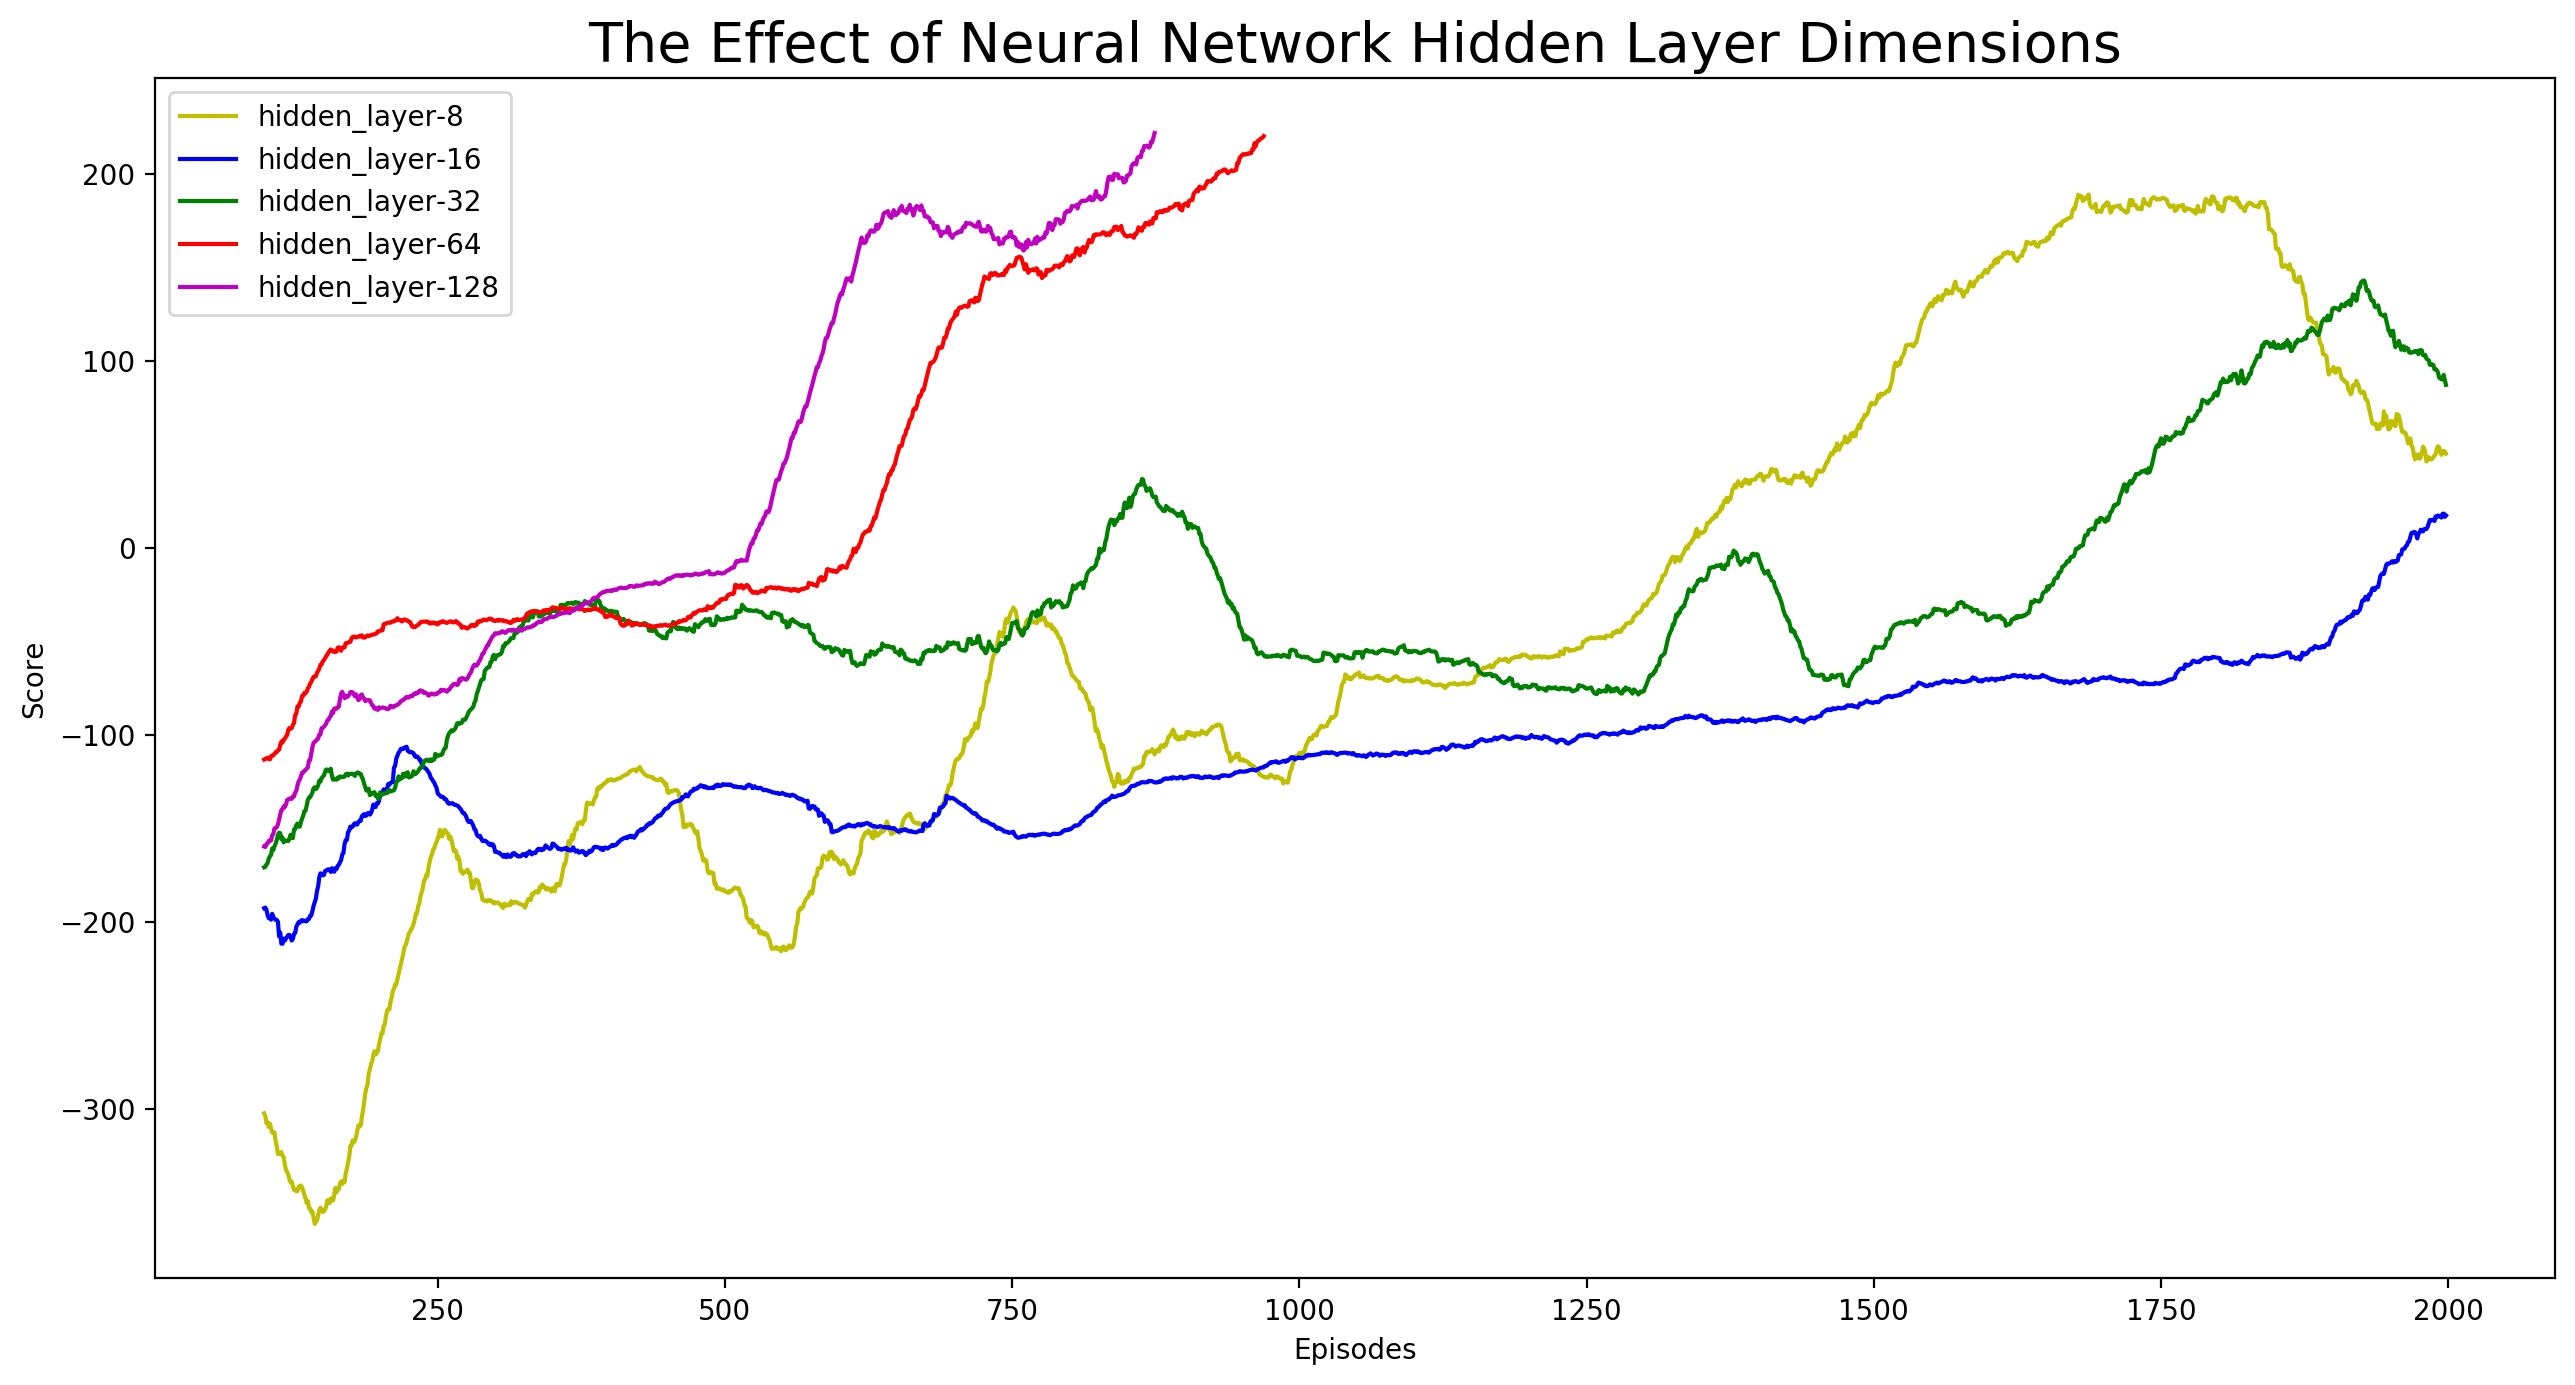

In [14]:
fig=plt.figure(figsize=(12,6),dpi=200)
ax=fig.add_axes([0,0,1,1])
hidden_layer8=ax.plot(pd.Series(scores[0]).rolling(window=100).mean(),'y',label='hidden_layer-8')
hidden_layer16=ax.plot(pd.Series(scores[1]).rolling(window=100).mean(),'b',label='hidden_layer-16',alpha=1)
hidden_layer32=ax.plot(pd.Series(scores[2]).rolling(window=100).mean(),'g',label='hidden_layer-32',alpha=1)
hidden_layer64=ax.plot(pd.Series(scores[3]).rolling(window=100).mean(),'r',label='hidden_layer-64',alpha=1)
hidden_layer128=ax.plot(pd.Series(scores[4]).rolling(window=100).mean(),'m',label='hidden_layer-128',alpha=1)
ax.legend(loc=0)
ax.set_title("The Effect of Neural Network Hidden Layer Dimensions",size=20)
ax.set_xlabel("Episodes")
ax.set_ylabel("Score")